# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import namedtuple
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
EPSILON = 1e-8 # small constant to avoid underflow or divide per 0
%matplotlib inline

# I - Data loading and preprocessing

## Load the data

#### This time, the data will correspond to greyscale images. <br> Two different datasets can be used here:
- The MNIST dataset, small 8*8 images, corresponding to handwritten digits &rightarrow; 10 classes
- The Fashion MNIST dataset, medium 28*28 images, corresponding to clothes pictures &rightarrow; 10 classes

#### Starting with the simple MNIST is recommended

In [3]:
dataset = "MNIST"
# dataset = "FASHION_MNIST"

In [4]:
def load_data(dataset='MNIST'):
    if dataset == 'MNIST':
        digits = load_digits()
        X, Y = np.asarray(digits['data'], dtype='float32'), np.asarray(digits['target'], dtype='int32')
        return X, Y
    elif dataset == 'FASHION_MNIST':
        import tensorflow as tf
        fashion_mnist = tf.keras.datasets.fashion_mnist
        (X, Y), (_, _) = fashion_mnist.load_data()
        X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))
        X, Y = np.asarray(X, dtype='float32'), np.asarray(Y, dtype='int32')
        return X, Y
X, Y = load_data(dataset=dataset)

In [5]:
n_classes = len(np.unique(Y))

In [6]:
print('Number of samples: {:d}'.format(X.shape[0]))
print('Input dimension: {:d}'.format(X.shape[1]))  # images 8x8 or 28*28 actually
print('Number of classes: {:d}'.format(n_classes))

Number of samples: 1797
Input dimension: 64
Number of classes: 10


In [7]:
print("Range max-min of greyscale pixel values: ({0:.1f}, {1:.1f})".format(np.max(X), np.min(X)))
print("First image sample:\n{0}".format(X[0]))
print("First image label: {0}".format(Y[0]))
print("Input design matrix shape: {0}".format(X.shape))

Range max-min of greyscale pixel values: (16.0, 0.0)
First image sample:
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
First image label: 0
Input design matrix shape: (1797, 64)


### What does the data look like?
Each image in the dataset consists of a 8 x 8 (or 28 x 28) matrix, of greyscale pixels. For the MNIST dataset, the values are between 0 and 16 where 0 represents white, 16 represents black and there are many shades of grey in-between. For the Fashion MNIST dataset, the values are between 0 and 255.<br>Each image is assigned a corresponding numerical label, so the image in ```X[i]``` has its corresponding label stored in ```Y[i]```.

The next cells below demonstrate how to visualise the input data. Make sure you understand what's happening, particularly how the indices correspond to individual items in the dataset. 

## Visualize the data

In [8]:
def visualize_data_sample(X, Y, nrows=2, ncols=2):
    fig, ax = plt.subplots(nrows, ncols)
    for row in ax:
        for col in row:
            index = random.randint(0, X.shape[0])
            dim = np.sqrt(X.shape[1]).astype(int)
            col.imshow(X[index].reshape((dim, dim)), cmap=plt.cm.gray_r)
            col.set_title("image label: %d" % Y[index])
    plt.tight_layout()
    plt.show()

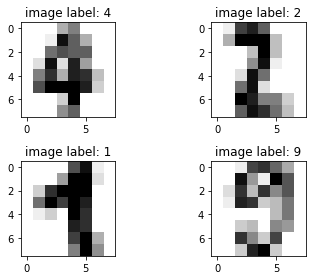

In [9]:
visualize_data_sample(X, Y)

# II - Multiclass classification MLP with Numpy

## II a) - Problem definition

<img src="../images/mlp_mnist.svg">

The task here will be to implement "from scratch" a Multilayer Perceptron for classification.

We will define the formal categorical cross entropy loss as follows:
$$
l(\mathbf{\Theta}, \mathbf{X}, \mathbf{Y}) = - \frac{1}{n} \sum_{i=1}^n \log \mathbf{f}(\mathbf{x}_i ; \mathbf{\Theta})^\top y_i
$$
<center>with $y_i$ being the one-hot encoded true label for the sample $i$, and $\Theta = (\mathbf{W}^h; \mathbf{b}^h; \mathbf{W}^o; \mathbf{b}^o)$</center>
<center>In addition, $\mathbf{f}(\mathbf{x}) = softmax(\mathbf{z^o}(\mathbf{x})) = softmax(\mathbf{W}^o\mathbf{h}(\mathbf{x}) + \mathbf{b}^o)$</center>
<center>and $\mathbf{h}(\mathbf{x}) = g(\mathbf{z^h}(\mathbf{x})) = g(\mathbf{W}^h\mathbf{x} + \mathbf{b}^h)$, $g$ being the activation function and could be implemented with $sigmoid$ or $relu$</center>

## Objectives:
- Write the categorical cross entropy loss function
- Write the activation functions with their associated gradient
- Write the softmax function that is going to be used to output the predicted probabilities
- Implement the forward pass through the neural network
- Implement the backpropagation according to the used loss: progagate the gradients using the chain rule and return $(\mathbf{\nabla_{W^h}}l ; \mathbf{\nabla_{b^h}}l ; \mathbf{\nabla_{W^o}}l ; \mathbf{\nabla_{b^o}}l)$
- Implement dropout regularization in the forward pass: be careful to consider both training and prediction cases
- Implement the SGD optimization algorithm, and improve it with simple momentum

#### Simple graph function to let you have a global overview:

<img src="../images/function_graph.png" style="width: 750px;"/>

### Hints

1) You may find numpy outer products useful: <br>
https://docs.scipy.org/doc/numpy/reference/generated/numpy.outer.html <br>
We have: $outer(u, v) = u \cdot v^T$, with $u, v$ two vectors

Example:

In [10]:
u, v = np.random.normal(size=(5,)), np.random.normal(size=(10,))
assert np.array_equal(
    np.outer(u, v),
    np.dot(np.reshape(u, (u.size, 1)), np.reshape(v, (1, v.size)))
)
assert np.outer(u, v).shape == (5, 10)

1) You also may find numpy matmul function useful: <br>
https://docs.scipy.org/doc/numpy/reference/generated/numpy.matmul.html <br>
It can be used to perform matrix products along one fixed dimension (i.e. the batch size)

Example:

In [11]:
A, B = np.random.randint(0, 100, size=(64, 5, 10)), np.random.randint(0, 100, size=(64, 10, 5))

In [12]:
assert np.array_equal(
    np.stack([np.dot(A_i, B_i) for A_i, B_i in zip(A, B)]),
    np.matmul(A, B)
)

## II b) - Implementation

In [91]:
class MultiLayerPerceptron():
    """MLP with one hidden layer having a hidden activation,
    and one output layer having a softmax activation"""
    def __init__(self, X, Y, hidden_size, activation='relu',
                 initialization='uniform', dropout=False, dropout_rate=1):
        # input, hidden, and output dimensions on the MLP based on X, Y
        self.input_size, self.output_size = X.shape[1], len(np.unique(Y))
        self.hidden_size = hidden_size
        # initialization strategies: avoid a full-0 initialization of the weight matrices
        if initialization == 'uniform':
            self.W_h = np.random.uniform(size=(self.hidden_size, self.input_size), high=0.01, low=-0.01)
            self.W_o = np.random.uniform(size=(self.output_size, self.hidden_size), high=0.01, low=-0.01)
        elif initialization == 'normal':
            self.W_h = np.random.normal(size=(self.hidden_size, self.input_size), loc=0, scale=0.01)
            self.W_o = np.random.normal(size=(self.output_size, self.hidden_size), loc=0, scale=0.01)
        # the bias could be initializated to 0 or a random low constant
        self.b_h = np.zeros(self.hidden_size)
        self.b_o = np.zeros(self.output_size)
        # our namedtuple structure of gradients
        self.Grads = namedtuple('Grads', ['W_h', 'b_h', 'W_o', 'b_o'])
        # and the velocities associated which are going to be useful for the momentum
        self.velocities = {'W_h': 0., 'b_h': 0., 'W_o': 0., 'b_o': 0.}
        # the hidden activation function used
        self.activation = activation
        # arrays to track back the losses and accuracies evolution
        self.training_losses_history = []
        self.validation_losses_history = []
        self.training_acc_history = []
        self.validation_acc_history = []
        # train val split and normalization of the features
        self.X_tr, self.X_val, self.Y_tr, self.Y_val = self.split_train_validation(X, Y)
        self.scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
        self.X_tr = self.scaler.fit_transform(self.X_tr)
        self.X_val = self.scaler.transform(self.X_val)
        # dropout parameters
        self.dropout = dropout
        self.dropout_rate = dropout_rate
        # step used for the optimization algorithm and setted later
        self.step = None
    
    # One-hot encoding of the target
    # Transform the integer represensation to a sparse one
    @staticmethod
    def one_hot(n_classes, Y):
        return np.eye(n_classes)[Y]
    
    # Reverse one-hot encoding of the target
    # Recover the former integer representation
    # ex: from (0,0,1,0) to 2
    @staticmethod
    def reverse_one_hot(Y_one_hot):
        return np.asarray(np.where(Y_one_hot==1)[1], dtype='int32')
    
    """
    Activation functions and their gradient
    """
    # In implementations below X is a matrix of shape (n_samples, p)
    
    # A max_value value is indicated for the relu and grad_relu functions
    # Make sure to clip the output to it to prevent numerical overflow (exploding gradient)
    # Make it so the max value reachable is max_value
    @staticmethod
    def relu(X, max_value=20):
        assert max_value > 0
        #TODO: (done)
        return np.maximum(0,np.clip(X,0,max_value))
    
    # Make it so the gradient becomes 0 when X becomes greater than max_value
    @staticmethod
    def grad_relu(X, max_value=20):
        assert max_value > 0
        # TODO: (done)
        return np.where(np.where(X < max_value, X, 0 ) < 0, 0, 1 )
    
    @staticmethod
    def sigmoid(X):
        # TODO: (done)
        return (1/(1+np.exp(-X)))
    
    @staticmethod
    def grad_sigmoid(X,sigmoid):
        # TODO: (done)
        return (sigmoid(X) * (1- sigmoid(X)))
    
    # Softmax function to output probabilities
    @staticmethod
    def softmax(X):
        # TODO: (done)
        return ( 1/np.sum(np.exp(X),axis=0) ) * np.exp(X) 
    
    # Loss function
    # Consider using EPSILON to prevent numerical issues (log(0) is undefined)
    # Y_true and Y_pred are of shape (n_samples,n_classes)
    @staticmethod
    def categorical_cross_entropy(Y_true, Y_pred):
        # TODO: (done)
        return -np.sum(Y_true * np.log(Y_pred + EPSILON))
    
    @staticmethod
    def split_train_validation(X, Y, test_size=0.25, seed=False):
        random_state = 42 if seed else np.random.randint(1e3)
        X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y, test_size=test_size, random_state=random_state)
        return X_tr, X_val, Y_tr, Y_val
    
    # Sample random batch in (X, Y) with a given batch_size for SGD
    @staticmethod
    def get_random_batch(X, Y, batch_size):
        indexes = np.random.choice(X.shape[0], size=batch_size, replace=False)
        return X[indexes], Y[indexes]
        
    # Forward pass: compute f(x) as y, and return optionally the hidden states h(x) and z_h(x) for compute_grads
    def forward(self, X, return_activation=False, training=False):
        if self.activation == 'relu':
            g_activation = self.relu
        elif self.activation == 'sigmoid':
            g_activation = self.sigmoid
        else:
            raise NotImplementedError
            
        #z_h = np.zeros((X.shape[0], self.hidden_size)) if len(X.shape) > 1 else np.zeros(self.hidden_size)
        #h = np.zeros((X.shape[0], self.hidden_size)) if len(X.shape) > 1 else np.zeros(self.hidden_size)
        # TODO: (done)
        z_h =  np.dot(X,self.W_h.T) + self.b_h
        h = g_activation(z_h)
        
        if self.dropout:
            if training:
                # TODO: (done)
                keep = np.where(np.random.uniform(size=h.shape) > self.dropout_rate, 1,0)
                h *= keep
            else:
                # TODO: (done)
                h *= self.dropout_rate


        # TODO: (done)
        #y = np.zeros((X.shape[0], self.output_size)) if len(X.shape) > 1 else np.zeros(self.output_size)  
        
        y = g_activation(np.dot(h,self.W_o.T) + self.b_o)
        
        #y = self.softmax(y)
        
        if return_activation:
            return y, h, z_h
        else:
            return y
    
    # Backpropagation: return an instantiation of self.Grads that contains the average gradients for the given batch
    def compute_grads(self, X, Y_true, vectorized=False):
        if self.activation == 'relu':
            g_grad = self.grad_relu
        elif self.activation == 'sigmoid':
            g_grad = self.grad_sigmoid
        else:
            raise NotImplementedError
        
        if len(X.shape) == 1:
            X = X.reshape((1,) + X.shape)
        
        if not vectorized:
            n = X.shape[0]
            grad_W_h = np.zeros((self.hidden_size, self.input_size))
            grad_b_h = np.zeros((self.hidden_size, )) 
            grad_W_o = np.zeros((self.output_size, self.hidden_size))
            grad_b_o = np.zeros((self.output_size, ))
            for x, y_true in zip(X, Y_true):
                y_pred, h, z_h = self.forward(x, return_activation=True, training=True)
                
                #calculate loss
                #one hot y true ????
                y_true_one_hot = self.one_hot(10,y_true)
                loss = self.categorical_cross_entropy(y_true_one_hot,y_pred)
                
                #calc activation gradients
                y_true_one_hot = self.one_hot(10,y_true)
                act_grad = y_pred - y_true_one_hot
                #print("act_grad",act_grad.shape)
                
                # TODO: (maybe done)
                grad_h   = self.W_o.T.dot(act_grad)
                #print("grad_h",grad_h.shape)
                grad_z_h = np.multiply(grad_h, self.grad_sigmoid(z_h,self.sigmoid) )
                #print("grad_z_h", grad_z_h.shape)
                
                #grad_W_h = grad_z_h.reshape((self.hidden_size,1)).dot(x.reshape((self.input_size,1)).T) #np.zeros((self.hidden_size, self.input_size))
                grad_W_h += np.outer(grad_z_h,x)
                #print("grad_W_h",grad_W_h.shape)
                grad_b_h += grad_z_h #np.zeros((self.hidden_size, )) 
                #print("grad_b_h",grad_b_h.shape)
                #grad_W_o = act_grad.dot(h.T) #np.zeros((self.output_size, self.hidden_size))
                grad_W_o += np.outer(act_grad,h)
                #print("grad_W_o",grad_W_o.shape)
                grad_b_o += act_grad # np.zeros((self.output_size, ))
                #print("grad_b_o",grad_b_o.shape)
                
            grads = self.Grads(grad_W_h/n, grad_b_h/n, grad_W_o/n, grad_b_o/n)
            
        else: 
            #print('doing vectorized grads')
            Y_pred, h, z_h = self.forward(X, return_activation=True, training=True)

            # TODO (optional), try to do the backprop without Python loops in a vectorized way:
              
            #calculate loss
            #one hot y true ????
            Y_true_one_hot = self.one_hot(10,Y_true)
            loss = self.categorical_cross_entropy(Y_true_one_hot,Y_pred)

            #calc activation gradients
            Y_true_one_hot = self.one_hot(10,Y_true)
            act_grad = Y_pred - Y_true_one_hot
            #print("act_grad",act_grad.shape)

            # TODO: (maybe done)
            
            #grad_h   = self.W_o.T.dot(act_grad)
            #print(self.W_o.shape)
            #print(act_grad.shape)
            grad_h   = np.dot(act_grad,self.W_o)
            
            #print("grad_h",grad_h.shape)
            grad_z_h = np.multiply(grad_h, self.grad_sigmoid(z_h,self.sigmoid) )
            #print("grad_z_h", grad_z_h.shape)

            #grad_W_h = grad_z_h.reshape((self.hidden_size,1)).dot(x.reshape((self.input_size,1)).T) #np.zeros((self.hidden_size, self.input_size))
            grad_W_h = np.outer(grad_z_h,X)
            #print("grad_W_h",grad_W_h.shape)
            grad_b_h = grad_z_h #np.zeros((self.hidden_size, )) 
            #print("grad_b_h",grad_b_h.shape)
            #grad_W_o = act_grad.dot(h.T) #np.zeros((self.output_size, self.hidden_size))
            grad_W_o = np.outer(act_grad,h)
            #print("grad_W_o",grad_W_o.shape)
            grad_b_o = act_grad # np.zeros((self.output_size, ))
            #print("grad_b_o",grad_b_o.shape)

            grads = self.Grads(
                np.mean(grad_W_h, axis=0), 
                np.mean(grad_b_h, axis=0), 
                np.mean(grad_W_o, axis=0), 
                np.mean(grad_b_o, axis=0))
            
        return grads
    
    # Perform the update of the parameters (W_h, b_h, W_o, b_o) based of their gradient
    def optimizer_step(self, optimizer='gd', momentum=False, momentum_alpha=0.9, 
                       batch_size=None, vectorized=False):
        if optimizer == 'gd':
            grads = self.compute_grads(self.X_tr, self.Y_tr, vectorized=vectorized)
        elif optimizer == 'sgd':
            batch_X_tr, batch_Y_tr = self.get_random_batch(self.X_tr, self.Y_tr, batch_size)
            grads = self.compute_grads(batch_X_tr, batch_Y_tr, vectorized=vectorized)
        else:
            raise NotImplementedError
        if not momentum:
            # TODO: (testing?)
            #update params
            self.W_h -= self.step * grads.W_h
            self.b_h -= self.step * grads.b_h
            self.W_o -= self.step * grads.W_o
            self.b_o -= self.step * grads.b_o
            pass
        else:
            # remember: use the stored velocities self.velocities = {'W_h': 0., 'b_h': 0., 'W_o': 0., 'b_o': 0.}
            # TODO: (testing)
            #update velocities
            
            self.velocities["W_h"] = momentum_alpha * self.velocities["W_h"] - self.step * grads.W_h
            self.velocities["W_o"] = momentum_alpha * self.velocities["W_o"] - self.step * grads.W_o
            self.velocities["b_h"] = momentum_alpha * self.velocities["b_h"] - self.step * grads.b_h
            self.velocities["b_o"] = momentum_alpha * self.velocities["b_o"] - self.step * grads.b_o
            
            #update params
            self.W_h += self.velocities["W_h"]
            self.b_h += self.velocities["b_h"]
            self.W_o += self.velocities["W_o"]
            self.b_o += self.velocities["b_o"]
            pass
    
    # Loss wrapper
    def loss(self, Y_true, Y_pred):
        return self.categorical_cross_entropy(self.one_hot(self.output_size, Y_true), Y_pred)
    
    def loss_history_flush(self):
        self.training_losses_history = []
        self.validation_losses_history = []
        
    # Main function that trains the MLP with a design matrix X and a target vector Y
    def train(self, optimizer='sgd', momentum=False, min_iterations=500, max_iterations=2000, initial_step=1e-1,
                batch_size=64, early_stopping=True, early_stopping_lookbehind=100, early_stopping_delta=1e-4, 
                vectorized=False, flush_history=True, verbose=True):
        if flush_history:
            self.loss_history_flush()
        cpt_patience, best_validation_loss = 0, np.inf
        iteration_number = 0
        self.step = initial_step
        while len(self.training_losses_history) < max_iterations:
            iteration_number += 1
            self.optimizer_step(
                optimizer=optimizer, momentum=momentum, batch_size=batch_size, vectorized=vectorized
                )
            
            training_loss = self.loss(self.Y_tr, self.forward(self.X_tr))
            self.training_losses_history.append(training_loss)
            training_accuracy = self.accuracy_on_train()
            self.training_acc_history.append(training_accuracy)
            validation_loss = self.loss(self.Y_val, self.forward(self.X_val))
            self.validation_losses_history.append(validation_loss)
            validation_accuracy = self.accuracy_on_validation()
            self.validation_acc_history.append(validation_accuracy)
            if iteration_number > min_iterations and early_stopping:
                if validation_loss + early_stopping_delta < best_validation_loss:
                    best_validation_loss = validation_loss
                    cpt_patience = 0
                else:
                    cpt_patience += 1
            if verbose:
                msg = "iteration number: {0}\t training loss: {1:.4f}\t" + \
                "validation loss: {2:.4f}\t validation accuracy: {3:.4f}"
                print(msg.format(iteration_number, 
                                 training_loss, 
                                 validation_loss,
                                 validation_accuracy))
            if cpt_patience >= early_stopping_lookbehind:
                break
    
    # Return the predicted class once the MLP has been trained
    def predict(self, X, normalize=True):
        if normalize:
            X = self.scaler.transform(X)
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
        
    """
    Metrics and plots
    """
    def accuracy_on_train(self):
        return (self.predict(self.X_tr, normalize=False) == self.Y_tr).mean()

    def accuracy_on_validation(self):
        return (self.predict(self.X_val, normalize=False) == self.Y_val).mean()

    def plot_loss_history(self, add_to_title=None):
        import warnings
        warnings.filterwarnings("ignore")
        plt.figure(figsize=(12, 8))
        plt.plot(range(len(self.training_losses_history)), 
                 self.training_losses_history, label='Training loss evolution')
        plt.plot(range(len(self.validation_losses_history)), 
                 self.validation_losses_history, label='Validation loss evolution')
        plt.legend(fontsize=15)
        plt.yscale('log')
        plt.xlabel("iteration number", fontsize=15)
        plt.ylabel("Cross entropy loss", fontsize=15)
        base_title = "Cross entropy loss evolution during training"
        if not self.dropout:
            base_title += ", no dropout penalization"
        else:
            base_title += ", {:.1f} dropout penalization"
            base_title = base_title.format(self.dropout_rate)
        title = base_title + ", " + add_to_title if add_to_title else base_title
        plt.title(title, fontsize=20)
        plt.show()
        
    def plot_validation_prediction(self, sample_id):
        fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
        classes = np.unique(self.Y_tr)
        dim = np.sqrt(self.X_val.shape[1]).astype(int)
        ax0.imshow(self.scaler.inverse_transform([self.X_val[sample_id]]).reshape(dim, dim), cmap=plt.cm.gray_r,
                   interpolation='nearest')
        ax0.set_title("True image label: %d" % self.Y_val[sample_id]);

        ax1.bar(classes, self.one_hot(len(classes), self.Y_val[sample_id]), label='true')
        ax1.bar(classes, self.forward(self.X_val[sample_id]), label='prediction', color="red")
        ax1.set_xticks(classes)
        prediction = self.predict(self.X_val[sample_id], normalize=False)
        ax1.set_title('Output probabilities (prediction: %d)' % prediction)
        ax1.set_xlabel('Digit class')
        ax1.legend()

In [43]:

#attention, gradient descent standard prend longtemp à converger 
mlp = MultiLayerPerceptron(X, Y, hidden_size=50, activation='sigmoid')
mlp.train(optimizer="gd",momentum=True)


iteration number: 1	 training loss: 1350.9978	validation loss: 451.5737	 validation accuracy: 0.0956
iteration number: 2	 training loss: 2185.9497	validation loss: 730.6288	 validation accuracy: 0.0956
iteration number: 3	 training loss: 3268.8478	validation loss: 1092.5570	 validation accuracy: 0.1200
iteration number: 4	 training loss: 4327.4979	validation loss: 1446.4505	 validation accuracy: 0.1000
iteration number: 5	 training loss: 5173.9630	validation loss: 1729.5451	 validation accuracy: 0.1000
iteration number: 6	 training loss: 5718.7387	validation loss: 1911.9330	 validation accuracy: 0.1000
iteration number: 7	 training loss: 5937.1542	validation loss: 1985.3404	 validation accuracy: 0.1000
iteration number: 8	 training loss: 5848.7596	validation loss: 1956.2482	 validation accuracy: 0.1000
iteration number: 9	 training loss: 5506.6192	validation loss: 1842.3237	 validation accuracy: 0.1178
iteration number: 10	 training loss: 4988.8011	validation loss: 1669.5888	 validatio

iteration number: 81	 training loss: 3118.7785	validation loss: 1043.2499	 validation accuracy: 0.1489
iteration number: 82	 training loss: 3123.4701	validation loss: 1044.8378	 validation accuracy: 0.1511
iteration number: 83	 training loss: 3126.0676	validation loss: 1045.7284	 validation accuracy: 0.1556
iteration number: 84	 training loss: 3126.5898	validation loss: 1045.9279	 validation accuracy: 0.1578
iteration number: 85	 training loss: 3125.1692	validation loss: 1045.4802	 validation accuracy: 0.1667
iteration number: 86	 training loss: 3122.0331	validation loss: 1044.4610	 validation accuracy: 0.1711
iteration number: 87	 training loss: 3117.4805	validation loss: 1042.9699	 validation accuracy: 0.1756
iteration number: 88	 training loss: 3111.8570	validation loss: 1041.1217	 validation accuracy: 0.1756
iteration number: 89	 training loss: 3105.5292	validation loss: 1039.0386	 validation accuracy: 0.1822
iteration number: 90	 training loss: 3098.8613	validation loss: 1036.8418

iteration number: 161	 training loss: 2195.0061	validation loss: 738.6606	 validation accuracy: 0.5933
iteration number: 162	 training loss: 2172.0368	validation loss: 730.8887	 validation accuracy: 0.6156
iteration number: 163	 training loss: 2149.3697	validation loss: 723.2146	 validation accuracy: 0.6378
iteration number: 164	 training loss: 2126.9823	validation loss: 715.6327	 validation accuracy: 0.6467
iteration number: 165	 training loss: 2104.8583	validation loss: 708.1389	 validation accuracy: 0.6644
iteration number: 166	 training loss: 2082.9885	validation loss: 700.7317	 validation accuracy: 0.6756
iteration number: 167	 training loss: 2061.3709	validation loss: 693.4115	 validation accuracy: 0.6844
iteration number: 168	 training loss: 2040.0102	validation loss: 686.1809	 validation accuracy: 0.6911
iteration number: 169	 training loss: 2018.9167	validation loss: 679.0438	 validation accuracy: 0.6911
iteration number: 170	 training loss: 1998.1045	validation loss: 672.0054

iteration number: 241	 training loss: 1013.7907	validation loss: 341.2087	 validation accuracy: 0.8556
iteration number: 242	 training loss: 1005.3445	validation loss: 338.3716	 validation accuracy: 0.8578
iteration number: 243	 training loss: 997.0205	validation loss: 335.5767	 validation accuracy: 0.8600
iteration number: 244	 training loss: 988.8155	validation loss: 332.8231	 validation accuracy: 0.8644
iteration number: 245	 training loss: 980.7263	validation loss: 330.1098	 validation accuracy: 0.8644
iteration number: 246	 training loss: 972.7497	validation loss: 327.4361	 validation accuracy: 0.8667
iteration number: 247	 training loss: 964.8827	validation loss: 324.8010	 validation accuracy: 0.8667
iteration number: 248	 training loss: 957.1226	validation loss: 322.2037	 validation accuracy: 0.8667
iteration number: 249	 training loss: 949.4666	validation loss: 319.6434	 validation accuracy: 0.8667
iteration number: 250	 training loss: 941.9118	validation loss: 317.1194	 valida

iteration number: 323	 training loss: 560.2320	validation loss: 195.0181	 validation accuracy: 0.9289
iteration number: 324	 training loss: 556.7226	validation loss: 193.9325	 validation accuracy: 0.9289
iteration number: 325	 training loss: 553.2520	validation loss: 192.8586	 validation accuracy: 0.9289
iteration number: 326	 training loss: 549.8199	validation loss: 191.7964	 validation accuracy: 0.9289
iteration number: 327	 training loss: 546.4260	validation loss: 190.7457	 validation accuracy: 0.9289
iteration number: 328	 training loss: 543.0701	validation loss: 189.7064	 validation accuracy: 0.9289
iteration number: 329	 training loss: 539.7518	validation loss: 188.6783	 validation accuracy: 0.9311
iteration number: 330	 training loss: 536.4708	validation loss: 187.6615	 validation accuracy: 0.9311
iteration number: 331	 training loss: 533.2268	validation loss: 186.6557	 validation accuracy: 0.9311
iteration number: 332	 training loss: 530.0195	validation loss: 185.6608	 validati

iteration number: 405	 training loss: 371.5191	validation loss: 135.9014	 validation accuracy: 0.9511
iteration number: 406	 training loss: 370.0848	validation loss: 135.4528	 validation accuracy: 0.9511
iteration number: 407	 training loss: 368.6637	validation loss: 135.0087	 validation accuracy: 0.9511
iteration number: 408	 training loss: 367.2557	validation loss: 134.5690	 validation accuracy: 0.9511
iteration number: 409	 training loss: 365.8606	validation loss: 134.1337	 validation accuracy: 0.9511
iteration number: 410	 training loss: 364.4782	validation loss: 133.7026	 validation accuracy: 0.9511
iteration number: 411	 training loss: 363.1083	validation loss: 133.2759	 validation accuracy: 0.9511
iteration number: 412	 training loss: 361.7508	validation loss: 132.8533	 validation accuracy: 0.9511
iteration number: 413	 training loss: 360.4054	validation loss: 132.4348	 validation accuracy: 0.9511
iteration number: 414	 training loss: 359.0719	validation loss: 132.0205	 validati

iteration number: 487	 training loss: 285.3977	validation loss: 110.0419	 validation accuracy: 0.9644
iteration number: 488	 training loss: 284.6267	validation loss: 109.8252	 validation accuracy: 0.9644
iteration number: 489	 training loss: 283.8605	validation loss: 109.6101	 validation accuracy: 0.9644
iteration number: 490	 training loss: 283.0990	validation loss: 109.3967	 validation accuracy: 0.9644
iteration number: 491	 training loss: 282.3421	validation loss: 109.1849	 validation accuracy: 0.9644
iteration number: 492	 training loss: 281.5899	validation loss: 108.9748	 validation accuracy: 0.9644
iteration number: 493	 training loss: 280.8423	validation loss: 108.7663	 validation accuracy: 0.9644
iteration number: 494	 training loss: 280.0992	validation loss: 108.5594	 validation accuracy: 0.9644
iteration number: 495	 training loss: 279.3606	validation loss: 108.3541	 validation accuracy: 0.9644
iteration number: 496	 training loss: 278.6264	validation loss: 108.1503	 validati

iteration number: 569	 training loss: 234.6923	validation loss: 96.6366	 validation accuracy: 0.9667
iteration number: 570	 training loss: 234.1972	validation loss: 96.5153	 validation accuracy: 0.9667
iteration number: 571	 training loss: 233.7045	validation loss: 96.3948	 validation accuracy: 0.9667
iteration number: 572	 training loss: 233.2140	validation loss: 96.2750	 validation accuracy: 0.9667
iteration number: 573	 training loss: 232.7259	validation loss: 96.1560	 validation accuracy: 0.9667
iteration number: 574	 training loss: 232.2400	validation loss: 96.0377	 validation accuracy: 0.9667
iteration number: 575	 training loss: 231.7564	validation loss: 95.9202	 validation accuracy: 0.9667
iteration number: 576	 training loss: 231.2750	validation loss: 95.8035	 validation accuracy: 0.9667
iteration number: 577	 training loss: 230.7959	validation loss: 95.6875	 validation accuracy: 0.9667
iteration number: 578	 training loss: 230.3190	validation loss: 95.5722	 validation accurac

iteration number: 651	 training loss: 200.5282	validation loss: 88.7798	 validation accuracy: 0.9667
iteration number: 652	 training loss: 200.1780	validation loss: 88.7050	 validation accuracy: 0.9667
iteration number: 653	 training loss: 199.8291	validation loss: 88.6306	 validation accuracy: 0.9667
iteration number: 654	 training loss: 199.4815	validation loss: 88.5565	 validation accuracy: 0.9667
iteration number: 655	 training loss: 199.1352	validation loss: 88.4829	 validation accuracy: 0.9667
iteration number: 656	 training loss: 198.7902	validation loss: 88.4097	 validation accuracy: 0.9667
iteration number: 657	 training loss: 198.4465	validation loss: 88.3368	 validation accuracy: 0.9667
iteration number: 658	 training loss: 198.1041	validation loss: 88.2643	 validation accuracy: 0.9667
iteration number: 659	 training loss: 197.7629	validation loss: 88.1923	 validation accuracy: 0.9667
iteration number: 660	 training loss: 197.4230	validation loss: 88.1206	 validation accurac

iteration number: 733	 training loss: 175.5457	validation loss: 83.7529	 validation accuracy: 0.9667
iteration number: 734	 training loss: 175.2807	validation loss: 83.7030	 validation accuracy: 0.9667
iteration number: 735	 training loss: 175.0166	validation loss: 83.6533	 validation accuracy: 0.9667
iteration number: 736	 training loss: 174.7532	validation loss: 83.6039	 validation accuracy: 0.9667
iteration number: 737	 training loss: 174.4907	validation loss: 83.5547	 validation accuracy: 0.9667
iteration number: 738	 training loss: 174.2290	validation loss: 83.5057	 validation accuracy: 0.9667
iteration number: 739	 training loss: 173.9680	validation loss: 83.4569	 validation accuracy: 0.9667
iteration number: 740	 training loss: 173.7079	validation loss: 83.4084	 validation accuracy: 0.9667
iteration number: 741	 training loss: 173.4485	validation loss: 83.3600	 validation accuracy: 0.9667
iteration number: 742	 training loss: 173.1899	validation loss: 83.3119	 validation accurac

iteration number: 815	 training loss: 156.1762	validation loss: 80.2963	 validation accuracy: 0.9667
iteration number: 816	 training loss: 155.9657	validation loss: 80.2608	 validation accuracy: 0.9667
iteration number: 817	 training loss: 155.7557	validation loss: 80.2254	 validation accuracy: 0.9667
iteration number: 818	 training loss: 155.5463	validation loss: 80.1902	 validation accuracy: 0.9667
iteration number: 819	 training loss: 155.3374	validation loss: 80.1551	 validation accuracy: 0.9667
iteration number: 820	 training loss: 155.1290	validation loss: 80.1202	 validation accuracy: 0.9667
iteration number: 821	 training loss: 154.9211	validation loss: 80.0854	 validation accuracy: 0.9667
iteration number: 822	 training loss: 154.7138	validation loss: 80.0507	 validation accuracy: 0.9667
iteration number: 823	 training loss: 154.5070	validation loss: 80.0161	 validation accuracy: 0.9667
iteration number: 824	 training loss: 154.3007	validation loss: 79.9817	 validation accurac

iteration number: 897	 training loss: 140.5101	validation loss: 77.7722	 validation accuracy: 0.9667
iteration number: 898	 training loss: 140.3369	validation loss: 77.7456	 validation accuracy: 0.9667
iteration number: 899	 training loss: 140.1640	validation loss: 77.7190	 validation accuracy: 0.9667
iteration number: 900	 training loss: 139.9914	validation loss: 77.6925	 validation accuracy: 0.9667
iteration number: 901	 training loss: 139.8193	validation loss: 77.6661	 validation accuracy: 0.9667
iteration number: 902	 training loss: 139.6476	validation loss: 77.6398	 validation accuracy: 0.9667
iteration number: 903	 training loss: 139.4762	validation loss: 77.6136	 validation accuracy: 0.9667
iteration number: 904	 training loss: 139.3052	validation loss: 77.5875	 validation accuracy: 0.9667
iteration number: 905	 training loss: 139.1345	validation loss: 77.5614	 validation accuracy: 0.9667
iteration number: 906	 training loss: 138.9643	validation loss: 77.5354	 validation accurac

iteration number: 979	 training loss: 127.4503	validation loss: 75.8354	 validation accuracy: 0.9667
iteration number: 980	 training loss: 127.3040	validation loss: 75.8145	 validation accuracy: 0.9667
iteration number: 981	 training loss: 127.1581	validation loss: 75.7937	 validation accuracy: 0.9667
iteration number: 982	 training loss: 127.0124	validation loss: 75.7729	 validation accuracy: 0.9667
iteration number: 983	 training loss: 126.8670	validation loss: 75.7521	 validation accuracy: 0.9667
iteration number: 984	 training loss: 126.7218	validation loss: 75.7314	 validation accuracy: 0.9667
iteration number: 985	 training loss: 126.5770	validation loss: 75.7108	 validation accuracy: 0.9667
iteration number: 986	 training loss: 126.4324	validation loss: 75.6902	 validation accuracy: 0.9667
iteration number: 987	 training loss: 126.2881	validation loss: 75.6697	 validation accuracy: 0.9667
iteration number: 988	 training loss: 126.1441	validation loss: 75.6492	 validation accurac

iteration number: 1061	 training loss: 116.3248	validation loss: 74.2887	 validation accuracy: 0.9667
iteration number: 1062	 training loss: 116.1991	validation loss: 74.2717	 validation accuracy: 0.9667
iteration number: 1063	 training loss: 116.0736	validation loss: 74.2548	 validation accuracy: 0.9667
iteration number: 1064	 training loss: 115.9483	validation loss: 74.2379	 validation accuracy: 0.9667
iteration number: 1065	 training loss: 115.8233	validation loss: 74.2210	 validation accuracy: 0.9667
iteration number: 1066	 training loss: 115.6984	validation loss: 74.2041	 validation accuracy: 0.9667
iteration number: 1067	 training loss: 115.5738	validation loss: 74.1873	 validation accuracy: 0.9667
iteration number: 1068	 training loss: 115.4494	validation loss: 74.1706	 validation accuracy: 0.9667
iteration number: 1069	 training loss: 115.3252	validation loss: 74.1539	 validation accuracy: 0.9667
iteration number: 1070	 training loss: 115.2013	validation loss: 74.1372	 validati

iteration number: 1143	 training loss: 106.6968	validation loss: 73.0147	 validation accuracy: 0.9667
iteration number: 1144	 training loss: 106.5873	validation loss: 73.0005	 validation accuracy: 0.9667
iteration number: 1145	 training loss: 106.4779	validation loss: 72.9863	 validation accuracy: 0.9667
iteration number: 1146	 training loss: 106.3688	validation loss: 72.9722	 validation accuracy: 0.9667
iteration number: 1147	 training loss: 106.2598	validation loss: 72.9581	 validation accuracy: 0.9667
iteration number: 1148	 training loss: 106.1510	validation loss: 72.9440	 validation accuracy: 0.9667
iteration number: 1149	 training loss: 106.0423	validation loss: 72.9300	 validation accuracy: 0.9667
iteration number: 1150	 training loss: 105.9339	validation loss: 72.9160	 validation accuracy: 0.9667
iteration number: 1151	 training loss: 105.8256	validation loss: 72.9020	 validation accuracy: 0.9667
iteration number: 1152	 training loss: 105.7175	validation loss: 72.8880	 validati

iteration number: 1225	 training loss: 98.2663	validation loss: 71.9410	 validation accuracy: 0.9667
iteration number: 1226	 training loss: 98.1699	validation loss: 71.9289	 validation accuracy: 0.9667
iteration number: 1227	 training loss: 98.0737	validation loss: 71.9169	 validation accuracy: 0.9667
iteration number: 1228	 training loss: 97.9776	validation loss: 71.9049	 validation accuracy: 0.9667
iteration number: 1229	 training loss: 97.8817	validation loss: 71.8929	 validation accuracy: 0.9667
iteration number: 1230	 training loss: 97.7859	validation loss: 71.8809	 validation accuracy: 0.9667
iteration number: 1231	 training loss: 97.6902	validation loss: 71.8689	 validation accuracy: 0.9667
iteration number: 1232	 training loss: 97.5947	validation loss: 71.8570	 validation accuracy: 0.9667
iteration number: 1233	 training loss: 97.4993	validation loss: 71.8451	 validation accuracy: 0.9667
iteration number: 1234	 training loss: 97.4041	validation loss: 71.8332	 validation accurac

iteration number: 1307	 training loss: 90.8179	validation loss: 71.0221	 validation accuracy: 0.9667
iteration number: 1308	 training loss: 90.7324	validation loss: 71.0117	 validation accuracy: 0.9667
iteration number: 1309	 training loss: 90.6471	validation loss: 71.0013	 validation accuracy: 0.9667
iteration number: 1310	 training loss: 90.5619	validation loss: 70.9910	 validation accuracy: 0.9667
iteration number: 1311	 training loss: 90.4767	validation loss: 70.9806	 validation accuracy: 0.9667
iteration number: 1312	 training loss: 90.3917	validation loss: 70.9703	 validation accuracy: 0.9667
iteration number: 1313	 training loss: 90.3069	validation loss: 70.9600	 validation accuracy: 0.9667
iteration number: 1314	 training loss: 90.2221	validation loss: 70.9498	 validation accuracy: 0.9667
iteration number: 1315	 training loss: 90.1375	validation loss: 70.9395	 validation accuracy: 0.9667
iteration number: 1316	 training loss: 90.0530	validation loss: 70.9293	 validation accurac

iteration number: 1389	 training loss: 84.1917	validation loss: 70.2285	 validation accuracy: 0.9667
iteration number: 1390	 training loss: 84.1154	validation loss: 70.2195	 validation accuracy: 0.9667
iteration number: 1391	 training loss: 84.0392	validation loss: 70.2106	 validation accuracy: 0.9667
iteration number: 1392	 training loss: 83.9632	validation loss: 70.2016	 validation accuracy: 0.9667
iteration number: 1393	 training loss: 83.8872	validation loss: 70.1926	 validation accuracy: 0.9667
iteration number: 1394	 training loss: 83.8113	validation loss: 70.1837	 validation accuracy: 0.9667
iteration number: 1395	 training loss: 83.7356	validation loss: 70.1748	 validation accuracy: 0.9667
iteration number: 1396	 training loss: 83.6599	validation loss: 70.1659	 validation accuracy: 0.9667
iteration number: 1397	 training loss: 83.5844	validation loss: 70.1570	 validation accuracy: 0.9667
iteration number: 1398	 training loss: 83.5089	validation loss: 70.1482	 validation accurac

iteration number: 1471	 training loss: 78.2655	validation loss: 69.5409	 validation accuracy: 0.9667
iteration number: 1472	 training loss: 78.1971	validation loss: 69.5331	 validation accuracy: 0.9667
iteration number: 1473	 training loss: 78.1288	validation loss: 69.5253	 validation accuracy: 0.9667
iteration number: 1474	 training loss: 78.0606	validation loss: 69.5176	 validation accuracy: 0.9667
iteration number: 1475	 training loss: 77.9926	validation loss: 69.5098	 validation accuracy: 0.9667
iteration number: 1476	 training loss: 77.9245	validation loss: 69.5021	 validation accuracy: 0.9667
iteration number: 1477	 training loss: 77.8566	validation loss: 69.4943	 validation accuracy: 0.9667
iteration number: 1478	 training loss: 77.7888	validation loss: 69.4866	 validation accuracy: 0.9667
iteration number: 1479	 training loss: 77.7211	validation loss: 69.4789	 validation accuracy: 0.9667
iteration number: 1480	 training loss: 77.6534	validation loss: 69.4713	 validation accurac

iteration number: 1553	 training loss: 72.9441	validation loss: 68.9458	 validation accuracy: 0.9667
iteration number: 1554	 training loss: 72.8826	validation loss: 68.9390	 validation accuracy: 0.9667
iteration number: 1555	 training loss: 72.8212	validation loss: 68.9323	 validation accuracy: 0.9667
iteration number: 1556	 training loss: 72.7599	validation loss: 68.9256	 validation accuracy: 0.9667
iteration number: 1557	 training loss: 72.6986	validation loss: 68.9189	 validation accuracy: 0.9667
iteration number: 1558	 training loss: 72.6374	validation loss: 68.9122	 validation accuracy: 0.9667
iteration number: 1559	 training loss: 72.5763	validation loss: 68.9056	 validation accuracy: 0.9667
iteration number: 1560	 training loss: 72.5153	validation loss: 68.8989	 validation accuracy: 0.9667
iteration number: 1561	 training loss: 72.4543	validation loss: 68.8923	 validation accuracy: 0.9667
iteration number: 1562	 training loss: 72.3935	validation loss: 68.8856	 validation accurac

iteration number: 1635	 training loss: 68.1509	validation loss: 68.4331	 validation accuracy: 0.9667
iteration number: 1636	 training loss: 68.0955	validation loss: 68.4273	 validation accuracy: 0.9667
iteration number: 1637	 training loss: 68.0401	validation loss: 68.4215	 validation accuracy: 0.9667
iteration number: 1638	 training loss: 67.9848	validation loss: 68.4158	 validation accuracy: 0.9667
iteration number: 1639	 training loss: 67.9295	validation loss: 68.4100	 validation accuracy: 0.9667
iteration number: 1640	 training loss: 67.8743	validation loss: 68.4043	 validation accuracy: 0.9667
iteration number: 1641	 training loss: 67.8192	validation loss: 68.3985	 validation accuracy: 0.9667
iteration number: 1642	 training loss: 67.7641	validation loss: 68.3928	 validation accuracy: 0.9667
iteration number: 1643	 training loss: 67.7091	validation loss: 68.3871	 validation accuracy: 0.9667
iteration number: 1644	 training loss: 67.6542	validation loss: 68.3814	 validation accurac

iteration number: 1717	 training loss: 63.8222	validation loss: 67.9943	 validation accuracy: 0.9667
iteration number: 1718	 training loss: 63.7721	validation loss: 67.9894	 validation accuracy: 0.9667
iteration number: 1719	 training loss: 63.7220	validation loss: 67.9845	 validation accuracy: 0.9667
iteration number: 1720	 training loss: 63.6719	validation loss: 67.9796	 validation accuracy: 0.9667
iteration number: 1721	 training loss: 63.6220	validation loss: 67.9747	 validation accuracy: 0.9667
iteration number: 1722	 training loss: 63.5721	validation loss: 67.9698	 validation accuracy: 0.9667
iteration number: 1723	 training loss: 63.5222	validation loss: 67.9649	 validation accuracy: 0.9667
iteration number: 1724	 training loss: 63.4724	validation loss: 67.9600	 validation accuracy: 0.9667
iteration number: 1725	 training loss: 63.4227	validation loss: 67.9552	 validation accuracy: 0.9667
iteration number: 1726	 training loss: 63.3730	validation loss: 67.9503	 validation accurac

iteration number: 1799	 training loss: 59.9032	validation loss: 67.6218	 validation accuracy: 0.9667
iteration number: 1800	 training loss: 59.8577	validation loss: 67.6176	 validation accuracy: 0.9667
iteration number: 1801	 training loss: 59.8123	validation loss: 67.6134	 validation accuracy: 0.9667
iteration number: 1802	 training loss: 59.7669	validation loss: 67.6093	 validation accuracy: 0.9667
iteration number: 1803	 training loss: 59.7216	validation loss: 67.6051	 validation accuracy: 0.9667
iteration number: 1804	 training loss: 59.6764	validation loss: 67.6010	 validation accuracy: 0.9667
iteration number: 1805	 training loss: 59.6312	validation loss: 67.5969	 validation accuracy: 0.9667
iteration number: 1806	 training loss: 59.5860	validation loss: 67.5928	 validation accuracy: 0.9667
iteration number: 1807	 training loss: 59.5409	validation loss: 67.5887	 validation accuracy: 0.9667
iteration number: 1808	 training loss: 59.4959	validation loss: 67.5846	 validation accurac

iteration number: 1881	 training loss: 56.3456	validation loss: 67.3078	 validation accuracy: 0.9689
iteration number: 1882	 training loss: 56.3043	validation loss: 67.3043	 validation accuracy: 0.9689
iteration number: 1883	 training loss: 56.2630	validation loss: 67.3009	 validation accuracy: 0.9689
iteration number: 1884	 training loss: 56.2218	validation loss: 67.2974	 validation accuracy: 0.9689
iteration number: 1885	 training loss: 56.1806	validation loss: 67.2939	 validation accuracy: 0.9689
iteration number: 1886	 training loss: 56.1394	validation loss: 67.2904	 validation accuracy: 0.9689
iteration number: 1887	 training loss: 56.0983	validation loss: 67.2870	 validation accuracy: 0.9689
iteration number: 1888	 training loss: 56.0573	validation loss: 67.2835	 validation accuracy: 0.9689
iteration number: 1889	 training loss: 56.0163	validation loss: 67.2801	 validation accuracy: 0.9689
iteration number: 1890	 training loss: 55.9753	validation loss: 67.2767	 validation accurac

iteration number: 1963	 training loss: 53.1070	validation loss: 67.0454	 validation accuracy: 0.9689
iteration number: 1964	 training loss: 53.0693	validation loss: 67.0425	 validation accuracy: 0.9689
iteration number: 1965	 training loss: 53.0316	validation loss: 67.0396	 validation accuracy: 0.9689
iteration number: 1966	 training loss: 52.9940	validation loss: 67.0367	 validation accuracy: 0.9689
iteration number: 1967	 training loss: 52.9565	validation loss: 67.0338	 validation accuracy: 0.9689
iteration number: 1968	 training loss: 52.9189	validation loss: 67.0309	 validation accuracy: 0.9689
iteration number: 1969	 training loss: 52.8815	validation loss: 67.0280	 validation accuracy: 0.9689
iteration number: 1970	 training loss: 52.8440	validation loss: 67.0252	 validation accuracy: 0.9689
iteration number: 1971	 training loss: 52.8066	validation loss: 67.0223	 validation accuracy: 0.9689
iteration number: 1972	 training loss: 52.7693	validation loss: 67.0194	 validation accurac

iteration number: 2045	 training loss: 50.1495	validation loss: 66.8277	 validation accuracy: 0.9689
iteration number: 2046	 training loss: 50.1150	validation loss: 66.8253	 validation accuracy: 0.9689
iteration number: 2047	 training loss: 50.0806	validation loss: 66.8229	 validation accuracy: 0.9689
iteration number: 2048	 training loss: 50.0462	validation loss: 66.8205	 validation accuracy: 0.9689
iteration number: 2049	 training loss: 50.0118	validation loss: 66.8181	 validation accuracy: 0.9689
iteration number: 2050	 training loss: 49.9775	validation loss: 66.8157	 validation accuracy: 0.9689
iteration number: 2051	 training loss: 49.9432	validation loss: 66.8134	 validation accuracy: 0.9689
iteration number: 2052	 training loss: 49.9089	validation loss: 66.8110	 validation accuracy: 0.9689
iteration number: 2053	 training loss: 49.8747	validation loss: 66.8086	 validation accuracy: 0.9689
iteration number: 2054	 training loss: 49.8405	validation loss: 66.8063	 validation accurac

iteration number: 2127	 training loss: 47.4402	validation loss: 66.6488	 validation accuracy: 0.9689
iteration number: 2128	 training loss: 47.4086	validation loss: 66.6468	 validation accuracy: 0.9689
iteration number: 2129	 training loss: 47.3770	validation loss: 66.6449	 validation accuracy: 0.9689
iteration number: 2130	 training loss: 47.3454	validation loss: 66.6429	 validation accuracy: 0.9689
iteration number: 2131	 training loss: 47.3139	validation loss: 66.6409	 validation accuracy: 0.9689
iteration number: 2132	 training loss: 47.2824	validation loss: 66.6390	 validation accuracy: 0.9689
iteration number: 2133	 training loss: 47.2509	validation loss: 66.6371	 validation accuracy: 0.9689
iteration number: 2134	 training loss: 47.2195	validation loss: 66.6351	 validation accuracy: 0.9689
iteration number: 2135	 training loss: 47.1881	validation loss: 66.6332	 validation accuracy: 0.9689
iteration number: 2136	 training loss: 47.1567	validation loss: 66.6313	 validation accurac

iteration number: 2209	 training loss: 44.9505	validation loss: 66.5034	 validation accuracy: 0.9689
iteration number: 2210	 training loss: 44.9214	validation loss: 66.5018	 validation accuracy: 0.9689
iteration number: 2211	 training loss: 44.8923	validation loss: 66.5002	 validation accuracy: 0.9689
iteration number: 2212	 training loss: 44.8633	validation loss: 66.4987	 validation accuracy: 0.9689
iteration number: 2213	 training loss: 44.8342	validation loss: 66.4971	 validation accuracy: 0.9689
iteration number: 2214	 training loss: 44.8053	validation loss: 66.4955	 validation accuracy: 0.9689
iteration number: 2215	 training loss: 44.7763	validation loss: 66.4940	 validation accuracy: 0.9689
iteration number: 2216	 training loss: 44.7473	validation loss: 66.4924	 validation accuracy: 0.9689
iteration number: 2217	 training loss: 44.7184	validation loss: 66.4908	 validation accuracy: 0.9689
iteration number: 2218	 training loss: 44.6896	validation loss: 66.4893	 validation accurac

iteration number: 2291	 training loss: 42.6558	validation loss: 66.3872	 validation accuracy: 0.9711
iteration number: 2292	 training loss: 42.6289	validation loss: 66.3859	 validation accuracy: 0.9711
iteration number: 2293	 training loss: 42.6021	validation loss: 66.3847	 validation accuracy: 0.9711
iteration number: 2294	 training loss: 42.5753	validation loss: 66.3834	 validation accuracy: 0.9711
iteration number: 2295	 training loss: 42.5485	validation loss: 66.3822	 validation accuracy: 0.9711
iteration number: 2296	 training loss: 42.5217	validation loss: 66.3809	 validation accuracy: 0.9711
iteration number: 2297	 training loss: 42.4950	validation loss: 66.3797	 validation accuracy: 0.9711
iteration number: 2298	 training loss: 42.4682	validation loss: 66.3785	 validation accuracy: 0.9711
iteration number: 2299	 training loss: 42.4416	validation loss: 66.3772	 validation accuracy: 0.9711
iteration number: 2300	 training loss: 42.4149	validation loss: 66.3760	 validation accurac

iteration number: 2373	 training loss: 40.5350	validation loss: 66.2965	 validation accuracy: 0.9711
iteration number: 2374	 training loss: 40.5101	validation loss: 66.2955	 validation accuracy: 0.9711
iteration number: 2375	 training loss: 40.4852	validation loss: 66.2945	 validation accuracy: 0.9711
iteration number: 2376	 training loss: 40.4604	validation loss: 66.2936	 validation accuracy: 0.9711
iteration number: 2377	 training loss: 40.4356	validation loss: 66.2926	 validation accuracy: 0.9711
iteration number: 2378	 training loss: 40.4108	validation loss: 66.2917	 validation accuracy: 0.9711
iteration number: 2379	 training loss: 40.3861	validation loss: 66.2907	 validation accuracy: 0.9711
iteration number: 2380	 training loss: 40.3614	validation loss: 66.2898	 validation accuracy: 0.9711
iteration number: 2381	 training loss: 40.3367	validation loss: 66.2889	 validation accuracy: 0.9711
iteration number: 2382	 training loss: 40.3120	validation loss: 66.2879	 validation accurac

iteration number: 2455	 training loss: 38.5700	validation loss: 66.2283	 validation accuracy: 0.9711
iteration number: 2456	 training loss: 38.5469	validation loss: 66.2276	 validation accuracy: 0.9711
iteration number: 2457	 training loss: 38.5238	validation loss: 66.2269	 validation accuracy: 0.9711
iteration number: 2458	 training loss: 38.5008	validation loss: 66.2262	 validation accuracy: 0.9711
iteration number: 2459	 training loss: 38.4778	validation loss: 66.2255	 validation accuracy: 0.9711
iteration number: 2460	 training loss: 38.4548	validation loss: 66.2248	 validation accuracy: 0.9711
iteration number: 2461	 training loss: 38.4319	validation loss: 66.2241	 validation accuracy: 0.9711
iteration number: 2462	 training loss: 38.4089	validation loss: 66.2234	 validation accuracy: 0.9711
iteration number: 2463	 training loss: 38.3860	validation loss: 66.2227	 validation accuracy: 0.9711
iteration number: 2464	 training loss: 38.3631	validation loss: 66.2221	 validation accurac

iteration number: 2537	 training loss: 36.7454	validation loss: 66.1802	 validation accuracy: 0.9711
iteration number: 2538	 training loss: 36.7240	validation loss: 66.1797	 validation accuracy: 0.9711
iteration number: 2539	 training loss: 36.7025	validation loss: 66.1793	 validation accuracy: 0.9711
iteration number: 2540	 training loss: 36.6811	validation loss: 66.1788	 validation accuracy: 0.9711
iteration number: 2541	 training loss: 36.6597	validation loss: 66.1783	 validation accuracy: 0.9711
iteration number: 2542	 training loss: 36.6384	validation loss: 66.1779	 validation accuracy: 0.9711
iteration number: 2543	 training loss: 36.6170	validation loss: 66.1774	 validation accuracy: 0.9711
iteration number: 2544	 training loss: 36.5957	validation loss: 66.1770	 validation accuracy: 0.9711
iteration number: 2545	 training loss: 36.5744	validation loss: 66.1765	 validation accuracy: 0.9711
iteration number: 2546	 training loss: 36.5531	validation loss: 66.1761	 validation accurac

iteration number: 2619	 training loss: 35.0480	validation loss: 66.1503	 validation accuracy: 0.9711
iteration number: 2620	 training loss: 35.0281	validation loss: 66.1500	 validation accuracy: 0.9711
iteration number: 2621	 training loss: 35.0081	validation loss: 66.1497	 validation accuracy: 0.9711
iteration number: 2622	 training loss: 34.9882	validation loss: 66.1495	 validation accuracy: 0.9711
iteration number: 2623	 training loss: 34.9683	validation loss: 66.1492	 validation accuracy: 0.9711
iteration number: 2624	 training loss: 34.9484	validation loss: 66.1490	 validation accuracy: 0.9711
iteration number: 2625	 training loss: 34.9285	validation loss: 66.1487	 validation accuracy: 0.9711
iteration number: 2626	 training loss: 34.9087	validation loss: 66.1485	 validation accuracy: 0.9711
iteration number: 2627	 training loss: 34.8888	validation loss: 66.1482	 validation accuracy: 0.9711
iteration number: 2628	 training loss: 34.8690	validation loss: 66.1480	 validation accurac

iteration number: 2701	 training loss: 33.4665	validation loss: 66.1368	 validation accuracy: 0.9711
iteration number: 2702	 training loss: 33.4478	validation loss: 66.1367	 validation accuracy: 0.9711
iteration number: 2703	 training loss: 33.4292	validation loss: 66.1367	 validation accuracy: 0.9711
iteration number: 2704	 training loss: 33.4107	validation loss: 66.1366	 validation accuracy: 0.9711
iteration number: 2705	 training loss: 33.3921	validation loss: 66.1365	 validation accuracy: 0.9711
iteration number: 2706	 training loss: 33.3735	validation loss: 66.1365	 validation accuracy: 0.9711
iteration number: 2707	 training loss: 33.3550	validation loss: 66.1364	 validation accuracy: 0.9711
iteration number: 2708	 training loss: 33.3365	validation loss: 66.1364	 validation accuracy: 0.9711
iteration number: 2709	 training loss: 33.3180	validation loss: 66.1363	 validation accuracy: 0.9711
iteration number: 2710	 training loss: 33.2995	validation loss: 66.1363	 validation accurac

iteration number: 2783	 training loss: 31.9907	validation loss: 66.1384	 validation accuracy: 0.9711
iteration number: 2784	 training loss: 31.9733	validation loss: 66.1385	 validation accuracy: 0.9711
iteration number: 2785	 training loss: 31.9559	validation loss: 66.1386	 validation accuracy: 0.9711
iteration number: 2786	 training loss: 31.9385	validation loss: 66.1387	 validation accuracy: 0.9711
iteration number: 2787	 training loss: 31.9212	validation loss: 66.1389	 validation accuracy: 0.9711
iteration number: 2788	 training loss: 31.9039	validation loss: 66.1390	 validation accuracy: 0.9711
iteration number: 2789	 training loss: 31.8866	validation loss: 66.1391	 validation accuracy: 0.9711
iteration number: 2790	 training loss: 31.8693	validation loss: 66.1392	 validation accuracy: 0.9711
iteration number: 2791	 training loss: 31.8520	validation loss: 66.1393	 validation accuracy: 0.9711
iteration number: 2792	 training loss: 31.8347	validation loss: 66.1395	 validation accurac

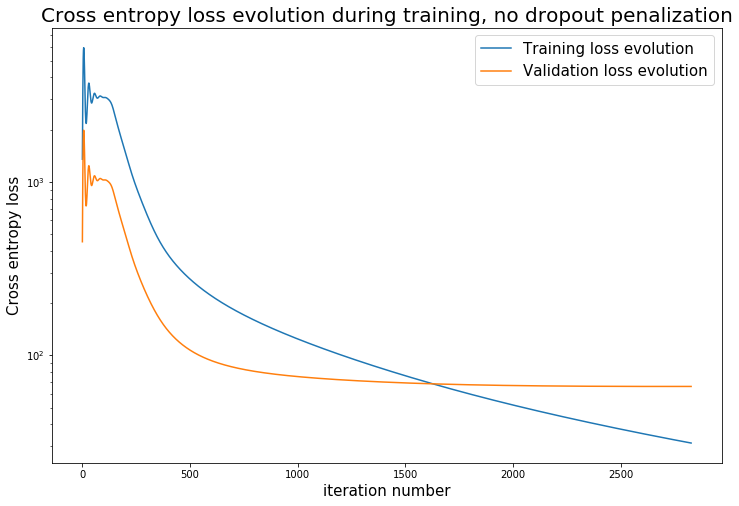

In [44]:
mlp.plot_loss_history()

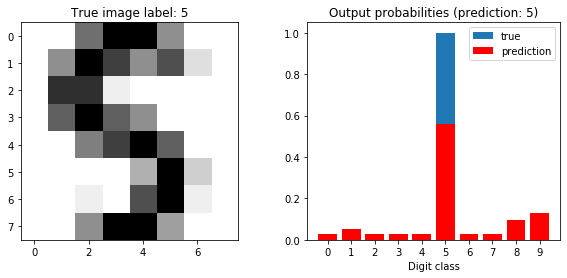

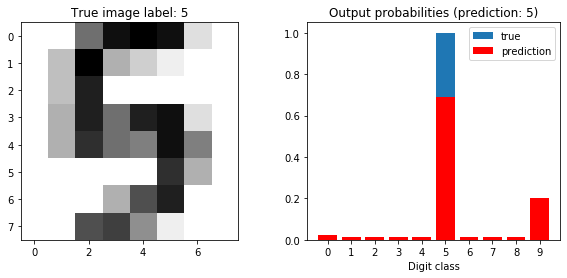

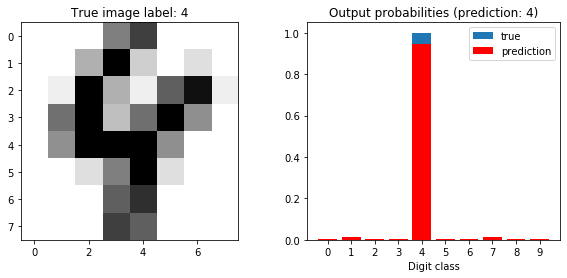

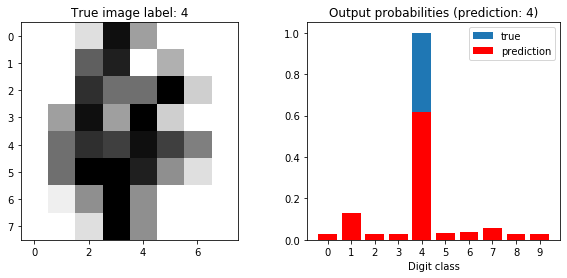

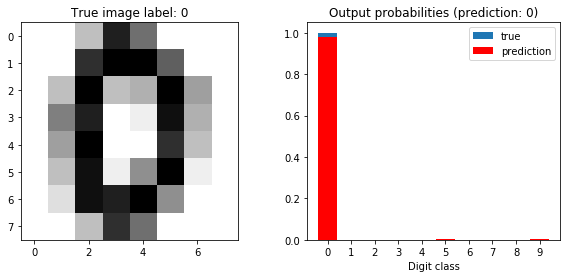

In [27]:
mlp.plot_validation_prediction(10)
mlp.plot_validation_prediction(11)
mlp.plot_validation_prediction(12)
mlp.plot_validation_prediction(13)
mlp.plot_validation_prediction(42)

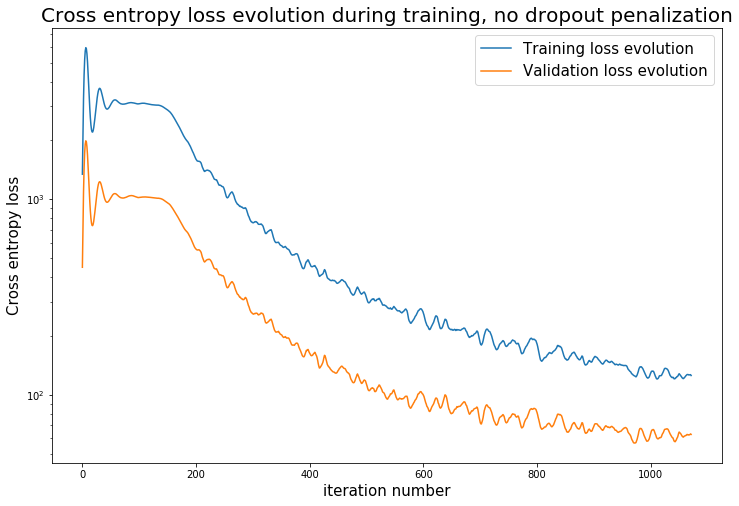

In [33]:
mlp.plot_loss_history()

In [34]:
mlp = MultiLayerPerceptron(X, Y, hidden_size=50, activation='sigmoid',dropout=True, dropout_rate=0.35)
mlp.train(momentum = True)

iteration number: 1	 training loss: 1038.8574	validation loss: 347.6607	 validation accuracy: 0.0978
iteration number: 2	 training loss: 1244.8550	validation loss: 417.1646	 validation accuracy: 0.0978
iteration number: 3	 training loss: 1540.1971	validation loss: 516.8967	 validation accuracy: 0.0978
iteration number: 4	 training loss: 1901.4492	validation loss: 639.2026	 validation accuracy: 0.0978
iteration number: 5	 training loss: 2288.5847	validation loss: 769.4916	 validation accuracy: 0.0822
iteration number: 6	 training loss: 2659.3944	validation loss: 893.6334	 validation accuracy: 0.0822
iteration number: 7	 training loss: 2972.5724	validation loss: 998.7390	 validation accuracy: 0.0822
iteration number: 8	 training loss: 3203.0097	validation loss: 1075.3432	 validation accuracy: 0.0822
iteration number: 9	 training loss: 3331.3033	validation loss: 1118.4789	 validation accuracy: 0.0822
iteration number: 10	 training loss: 3356.3276	validation loss: 1127.0221	 validation acc

iteration number: 83	 training loss: 2419.3989	validation loss: 816.2535	 validation accuracy: 0.0711
iteration number: 84	 training loss: 2421.7170	validation loss: 816.8369	 validation accuracy: 0.0711
iteration number: 85	 training loss: 2423.7861	validation loss: 817.5899	 validation accuracy: 0.0711
iteration number: 86	 training loss: 2426.9954	validation loss: 818.5768	 validation accuracy: 0.0711
iteration number: 87	 training loss: 2430.5513	validation loss: 819.5204	 validation accuracy: 0.0711
iteration number: 88	 training loss: 2435.0563	validation loss: 820.9411	 validation accuracy: 0.0711
iteration number: 89	 training loss: 2439.8616	validation loss: 822.7093	 validation accuracy: 0.0711
iteration number: 90	 training loss: 2443.6284	validation loss: 824.1350	 validation accuracy: 0.0711
iteration number: 91	 training loss: 2445.8630	validation loss: 824.6656	 validation accuracy: 0.0711
iteration number: 92	 training loss: 2447.1111	validation loss: 824.7249	 validati

iteration number: 168	 training loss: 1865.3564	validation loss: 632.6726	 validation accuracy: 0.5156
iteration number: 169	 training loss: 1857.3364	validation loss: 629.1428	 validation accuracy: 0.5200
iteration number: 170	 training loss: 1848.7369	validation loss: 625.1374	 validation accuracy: 0.5511
iteration number: 171	 training loss: 1839.9083	validation loss: 621.1193	 validation accuracy: 0.5978
iteration number: 172	 training loss: 1831.0044	validation loss: 616.9240	 validation accuracy: 0.6644
iteration number: 173	 training loss: 1819.8221	validation loss: 612.1031	 validation accuracy: 0.6844
iteration number: 174	 training loss: 1809.0003	validation loss: 607.4504	 validation accuracy: 0.7000
iteration number: 175	 training loss: 1800.1572	validation loss: 603.4949	 validation accuracy: 0.7244
iteration number: 176	 training loss: 1793.0231	validation loss: 600.1767	 validation accuracy: 0.7467
iteration number: 177	 training loss: 1785.9214	validation loss: 597.3627

iteration number: 249	 training loss: 1337.0912	validation loss: 441.0233	 validation accuracy: 0.8800
iteration number: 250	 training loss: 1335.0484	validation loss: 441.3748	 validation accuracy: 0.8778
iteration number: 251	 training loss: 1333.6072	validation loss: 442.5126	 validation accuracy: 0.8733
iteration number: 252	 training loss: 1334.4973	validation loss: 444.4037	 validation accuracy: 0.8622
iteration number: 253	 training loss: 1336.3252	validation loss: 447.0063	 validation accuracy: 0.8489
iteration number: 254	 training loss: 1340.0408	validation loss: 449.7953	 validation accuracy: 0.8467
iteration number: 255	 training loss: 1342.6560	validation loss: 451.5692	 validation accuracy: 0.8467
iteration number: 256	 training loss: 1345.6359	validation loss: 453.3193	 validation accuracy: 0.8511
iteration number: 257	 training loss: 1348.0063	validation loss: 454.1914	 validation accuracy: 0.8578
iteration number: 258	 training loss: 1349.1477	validation loss: 454.4800

iteration number: 330	 training loss: 1080.6589	validation loss: 358.3014	 validation accuracy: 0.9111
iteration number: 331	 training loss: 1081.3095	validation loss: 358.7074	 validation accuracy: 0.9133
iteration number: 332	 training loss: 1083.1268	validation loss: 359.4157	 validation accuracy: 0.9178
iteration number: 333	 training loss: 1084.7199	validation loss: 359.8203	 validation accuracy: 0.9244
iteration number: 334	 training loss: 1088.1562	validation loss: 360.9187	 validation accuracy: 0.9333
iteration number: 335	 training loss: 1091.3490	validation loss: 362.1762	 validation accuracy: 0.9356
iteration number: 336	 training loss: 1095.3179	validation loss: 363.7893	 validation accuracy: 0.9378
iteration number: 337	 training loss: 1101.9456	validation loss: 366.1699	 validation accuracy: 0.9400
iteration number: 338	 training loss: 1107.8273	validation loss: 368.0263	 validation accuracy: 0.9400
iteration number: 339	 training loss: 1110.7671	validation loss: 369.1200

iteration number: 416	 training loss: 975.3341	validation loss: 325.2731	 validation accuracy: 0.9444
iteration number: 417	 training loss: 969.8984	validation loss: 323.4820	 validation accuracy: 0.9400
iteration number: 418	 training loss: 963.1778	validation loss: 321.1259	 validation accuracy: 0.9422
iteration number: 419	 training loss: 954.2011	validation loss: 317.9640	 validation accuracy: 0.9422
iteration number: 420	 training loss: 946.7197	validation loss: 315.3997	 validation accuracy: 0.9378
iteration number: 421	 training loss: 941.1032	validation loss: 313.2242	 validation accuracy: 0.9378
iteration number: 422	 training loss: 936.4475	validation loss: 311.3761	 validation accuracy: 0.9378
iteration number: 423	 training loss: 929.9547	validation loss: 309.1969	 validation accuracy: 0.9400
iteration number: 424	 training loss: 924.1018	validation loss: 307.2542	 validation accuracy: 0.9400
iteration number: 425	 training loss: 919.9509	validation loss: 305.9638	 validati

iteration number: 498	 training loss: 837.6624	validation loss: 282.8898	 validation accuracy: 0.9533
iteration number: 499	 training loss: 839.0626	validation loss: 282.8393	 validation accuracy: 0.9533
iteration number: 500	 training loss: 840.5408	validation loss: 282.6334	 validation accuracy: 0.9556
iteration number: 501	 training loss: 841.0743	validation loss: 282.2330	 validation accuracy: 0.9556
iteration number: 502	 training loss: 842.0684	validation loss: 282.1228	 validation accuracy: 0.9533
iteration number: 503	 training loss: 840.0042	validation loss: 281.3524	 validation accuracy: 0.9556
iteration number: 504	 training loss: 841.1237	validation loss: 281.6664	 validation accuracy: 0.9556
iteration number: 505	 training loss: 843.9407	validation loss: 282.5828	 validation accuracy: 0.9556
iteration number: 506	 training loss: 845.5277	validation loss: 283.0026	 validation accuracy: 0.9556
iteration number: 507	 training loss: 845.6054	validation loss: 283.0707	 validati

iteration number: 579	 training loss: 767.3077	validation loss: 260.5710	 validation accuracy: 0.9578
iteration number: 580	 training loss: 764.5781	validation loss: 259.8540	 validation accuracy: 0.9600
iteration number: 581	 training loss: 762.5148	validation loss: 259.3551	 validation accuracy: 0.9600
iteration number: 582	 training loss: 758.9040	validation loss: 258.2838	 validation accuracy: 0.9644
iteration number: 583	 training loss: 755.7138	validation loss: 257.2904	 validation accuracy: 0.9644
iteration number: 584	 training loss: 752.2469	validation loss: 256.0245	 validation accuracy: 0.9644
iteration number: 585	 training loss: 749.4363	validation loss: 255.1649	 validation accuracy: 0.9644
iteration number: 586	 training loss: 745.4436	validation loss: 253.9412	 validation accuracy: 0.9667
iteration number: 587	 training loss: 743.9193	validation loss: 253.9004	 validation accuracy: 0.9667
iteration number: 588	 training loss: 743.8597	validation loss: 254.4640	 validati

iteration number: 660	 training loss: 714.2947	validation loss: 246.2931	 validation accuracy: 0.9622
iteration number: 661	 training loss: 711.9411	validation loss: 245.0867	 validation accuracy: 0.9600
iteration number: 662	 training loss: 708.3798	validation loss: 243.3366	 validation accuracy: 0.9578
iteration number: 663	 training loss: 703.6420	validation loss: 241.2246	 validation accuracy: 0.9578
iteration number: 664	 training loss: 701.5816	validation loss: 240.0246	 validation accuracy: 0.9578
iteration number: 665	 training loss: 700.2026	validation loss: 239.1092	 validation accuracy: 0.9600
iteration number: 666	 training loss: 698.9964	validation loss: 238.2760	 validation accuracy: 0.9600
iteration number: 667	 training loss: 697.2492	validation loss: 237.4287	 validation accuracy: 0.9600
iteration number: 668	 training loss: 695.4680	validation loss: 236.6979	 validation accuracy: 0.9622
iteration number: 669	 training loss: 693.4080	validation loss: 236.0836	 validati

iteration number: 743	 training loss: 658.2203	validation loss: 225.5182	 validation accuracy: 0.9644
iteration number: 744	 training loss: 653.7199	validation loss: 224.1491	 validation accuracy: 0.9622
iteration number: 745	 training loss: 650.1125	validation loss: 223.1724	 validation accuracy: 0.9622
iteration number: 746	 training loss: 647.8231	validation loss: 222.6828	 validation accuracy: 0.9622
iteration number: 747	 training loss: 646.2763	validation loss: 222.4444	 validation accuracy: 0.9644
iteration number: 748	 training loss: 644.7447	validation loss: 222.0920	 validation accuracy: 0.9622
iteration number: 749	 training loss: 643.0688	validation loss: 221.8142	 validation accuracy: 0.9578
iteration number: 750	 training loss: 641.6540	validation loss: 221.5620	 validation accuracy: 0.9578
iteration number: 751	 training loss: 640.2423	validation loss: 221.3110	 validation accuracy: 0.9622
iteration number: 752	 training loss: 638.3708	validation loss: 220.8217	 validati

iteration number: 828	 training loss: 624.4517	validation loss: 215.0215	 validation accuracy: 0.9622
iteration number: 829	 training loss: 626.1425	validation loss: 215.2993	 validation accuracy: 0.9622
iteration number: 830	 training loss: 629.1195	validation loss: 216.1773	 validation accuracy: 0.9644
iteration number: 831	 training loss: 631.3482	validation loss: 216.7955	 validation accuracy: 0.9644
iteration number: 832	 training loss: 634.1153	validation loss: 217.7062	 validation accuracy: 0.9644
iteration number: 833	 training loss: 635.6191	validation loss: 218.2258	 validation accuracy: 0.9644
iteration number: 834	 training loss: 637.1203	validation loss: 218.7827	 validation accuracy: 0.9622
iteration number: 835	 training loss: 638.2983	validation loss: 219.4335	 validation accuracy: 0.9644
iteration number: 836	 training loss: 638.7819	validation loss: 219.7596	 validation accuracy: 0.9644
iteration number: 837	 training loss: 639.5660	validation loss: 220.1059	 validati

iteration number: 910	 training loss: 585.2611	validation loss: 204.7515	 validation accuracy: 0.9667
iteration number: 911	 training loss: 586.3364	validation loss: 205.3783	 validation accuracy: 0.9667
iteration number: 912	 training loss: 587.6590	validation loss: 206.0417	 validation accuracy: 0.9689
iteration number: 913	 training loss: 591.2254	validation loss: 207.2041	 validation accuracy: 0.9689
iteration number: 914	 training loss: 594.4742	validation loss: 208.2291	 validation accuracy: 0.9689
iteration number: 915	 training loss: 597.3420	validation loss: 209.0446	 validation accuracy: 0.9689
iteration number: 916	 training loss: 597.4007	validation loss: 208.7673	 validation accuracy: 0.9711
iteration number: 917	 training loss: 597.5632	validation loss: 208.5676	 validation accuracy: 0.9711
iteration number: 918	 training loss: 598.3511	validation loss: 208.6957	 validation accuracy: 0.9689
iteration number: 919	 training loss: 597.4311	validation loss: 208.1804	 validati

iteration number: 991	 training loss: 567.4466	validation loss: 198.5530	 validation accuracy: 0.9711
iteration number: 992	 training loss: 566.3383	validation loss: 198.1098	 validation accuracy: 0.9711
iteration number: 993	 training loss: 565.1840	validation loss: 197.5440	 validation accuracy: 0.9711
iteration number: 994	 training loss: 564.0382	validation loss: 196.9190	 validation accuracy: 0.9711
iteration number: 995	 training loss: 561.8191	validation loss: 195.9914	 validation accuracy: 0.9711
iteration number: 996	 training loss: 561.8854	validation loss: 195.8001	 validation accuracy: 0.9711
iteration number: 997	 training loss: 561.4682	validation loss: 195.4492	 validation accuracy: 0.9711
iteration number: 998	 training loss: 562.1071	validation loss: 195.6769	 validation accuracy: 0.9711
iteration number: 999	 training loss: 563.6231	validation loss: 196.3810	 validation accuracy: 0.9711
iteration number: 1000	 training loss: 564.9064	validation loss: 197.2643	 validat

iteration number: 1072	 training loss: 559.0697	validation loss: 199.4411	 validation accuracy: 0.9689
iteration number: 1073	 training loss: 560.8997	validation loss: 200.3505	 validation accuracy: 0.9689
iteration number: 1074	 training loss: 563.0970	validation loss: 201.3167	 validation accuracy: 0.9689
iteration number: 1075	 training loss: 564.9481	validation loss: 202.0931	 validation accuracy: 0.9622
iteration number: 1076	 training loss: 565.8937	validation loss: 202.4833	 validation accuracy: 0.9622
iteration number: 1077	 training loss: 567.0242	validation loss: 202.8057	 validation accuracy: 0.9622
iteration number: 1078	 training loss: 566.9669	validation loss: 202.6254	 validation accuracy: 0.9600
iteration number: 1079	 training loss: 566.6013	validation loss: 202.2528	 validation accuracy: 0.9578
iteration number: 1080	 training loss: 566.9216	validation loss: 202.1172	 validation accuracy: 0.9578
iteration number: 1081	 training loss: 567.3899	validation loss: 202.1076

iteration number: 1156	 training loss: 549.7926	validation loss: 194.8782	 validation accuracy: 0.9689
iteration number: 1157	 training loss: 550.5085	validation loss: 195.0102	 validation accuracy: 0.9689
iteration number: 1158	 training loss: 550.5201	validation loss: 194.9669	 validation accuracy: 0.9711
iteration number: 1159	 training loss: 551.5994	validation loss: 195.3861	 validation accuracy: 0.9711
iteration number: 1160	 training loss: 552.0680	validation loss: 195.4223	 validation accuracy: 0.9711
iteration number: 1161	 training loss: 552.1918	validation loss: 195.3787	 validation accuracy: 0.9733
iteration number: 1162	 training loss: 552.9855	validation loss: 195.6054	 validation accuracy: 0.9733
iteration number: 1163	 training loss: 552.5592	validation loss: 195.4713	 validation accuracy: 0.9733
iteration number: 1164	 training loss: 552.4865	validation loss: 195.4345	 validation accuracy: 0.9733
iteration number: 1165	 training loss: 552.0196	validation loss: 195.3233

iteration number: 1242	 training loss: 529.4304	validation loss: 188.6183	 validation accuracy: 0.9689
iteration number: 1243	 training loss: 529.8358	validation loss: 188.9247	 validation accuracy: 0.9689
iteration number: 1244	 training loss: 530.4537	validation loss: 189.2404	 validation accuracy: 0.9689
iteration number: 1245	 training loss: 530.8576	validation loss: 189.4063	 validation accuracy: 0.9711
iteration number: 1246	 training loss: 531.9971	validation loss: 189.7219	 validation accuracy: 0.9733
iteration number: 1247	 training loss: 532.6657	validation loss: 189.8523	 validation accuracy: 0.9756
iteration number: 1248	 training loss: 532.9746	validation loss: 189.9253	 validation accuracy: 0.9756
iteration number: 1249	 training loss: 532.6260	validation loss: 189.8543	 validation accuracy: 0.9756
iteration number: 1250	 training loss: 531.5692	validation loss: 189.6155	 validation accuracy: 0.9756
iteration number: 1251	 training loss: 528.7287	validation loss: 188.7247

iteration number: 1326	 training loss: 515.3711	validation loss: 183.1888	 validation accuracy: 0.9756
iteration number: 1327	 training loss: 515.6600	validation loss: 183.1920	 validation accuracy: 0.9756
iteration number: 1328	 training loss: 516.0648	validation loss: 183.2491	 validation accuracy: 0.9733
iteration number: 1329	 training loss: 516.0727	validation loss: 183.1566	 validation accuracy: 0.9733
iteration number: 1330	 training loss: 514.8262	validation loss: 182.7762	 validation accuracy: 0.9711
iteration number: 1331	 training loss: 514.0626	validation loss: 182.4963	 validation accuracy: 0.9711
iteration number: 1332	 training loss: 513.4351	validation loss: 182.3456	 validation accuracy: 0.9667
iteration number: 1333	 training loss: 512.2140	validation loss: 181.9513	 validation accuracy: 0.9667
iteration number: 1334	 training loss: 510.5568	validation loss: 181.3170	 validation accuracy: 0.9689
iteration number: 1335	 training loss: 507.2682	validation loss: 180.2628

iteration number: 1409	 training loss: 487.5541	validation loss: 175.3209	 validation accuracy: 0.9756
iteration number: 1410	 training loss: 489.6764	validation loss: 176.0609	 validation accuracy: 0.9756
iteration number: 1411	 training loss: 490.3165	validation loss: 176.3726	 validation accuracy: 0.9756
iteration number: 1412	 training loss: 490.9198	validation loss: 176.7854	 validation accuracy: 0.9733
iteration number: 1413	 training loss: 490.8391	validation loss: 177.0266	 validation accuracy: 0.9756
iteration number: 1414	 training loss: 490.2297	validation loss: 177.1100	 validation accuracy: 0.9756
iteration number: 1415	 training loss: 489.3273	validation loss: 177.0225	 validation accuracy: 0.9756
iteration number: 1416	 training loss: 488.9770	validation loss: 177.0941	 validation accuracy: 0.9756
iteration number: 1417	 training loss: 489.6220	validation loss: 177.4955	 validation accuracy: 0.9756
iteration number: 1418	 training loss: 488.8728	validation loss: 177.3501

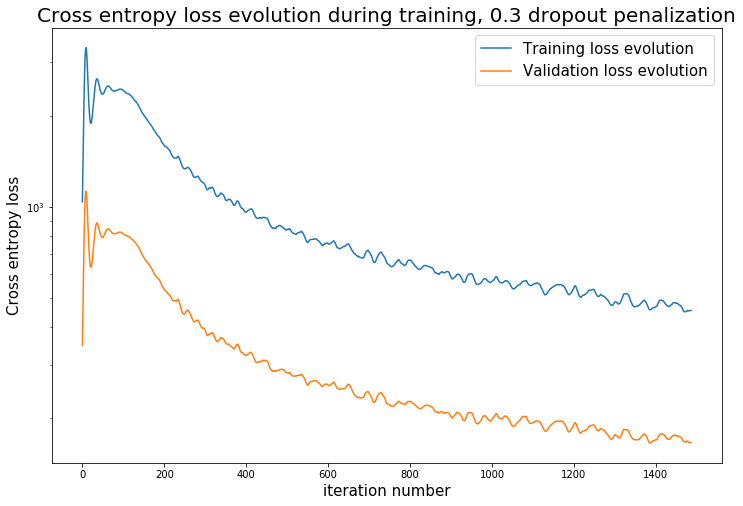

In [35]:
mlp.plot_loss_history()

In [51]:
mlp = MultiLayerPerceptron(X, Y, hidden_size=200, activation='relu',dropout=True, dropout_rate=0.35)
mlp.train(momentum = True)

iteration number: 1	 training loss: 6488.8875	validation loss: 2194.4479	 validation accuracy: 0.1067
iteration number: 2	 training loss: 4871.8526	validation loss: 1629.7539	 validation accuracy: 0.0978
iteration number: 3	 training loss: 4010.4858	validation loss: 1342.7287	 validation accuracy: 0.0978
iteration number: 4	 training loss: 3453.5548	validation loss: 1158.2845	 validation accuracy: 0.0889
iteration number: 5	 training loss: 3071.1378	validation loss: 1028.8177	 validation accuracy: 0.0933
iteration number: 6	 training loss: 2802.3217	validation loss: 937.8322	 validation accuracy: 0.0933
iteration number: 7	 training loss: 2623.0596	validation loss: 876.8890	 validation accuracy: 0.0933
iteration number: 8	 training loss: 2520.2888	validation loss: 840.7812	 validation accuracy: 0.0933
iteration number: 9	 training loss: 2484.0454	validation loss: 826.7820	 validation accuracy: 0.0933
iteration number: 10	 training loss: 2505.6489	validation loss: 832.2459	 validation a

iteration number: 84	 training loss: 1964.2892	validation loss: 658.7026	 validation accuracy: 0.8467
iteration number: 85	 training loss: 1959.6534	validation loss: 653.4578	 validation accuracy: 0.8644
iteration number: 86	 training loss: 1940.6527	validation loss: 647.4228	 validation accuracy: 0.8533
iteration number: 87	 training loss: 1920.0250	validation loss: 641.4007	 validation accuracy: 0.8578
iteration number: 88	 training loss: 1902.7486	validation loss: 636.4286	 validation accuracy: 0.8556
iteration number: 89	 training loss: 1898.0920	validation loss: 633.4688	 validation accuracy: 0.8578
iteration number: 90	 training loss: 1889.8170	validation loss: 631.8593	 validation accuracy: 0.8533
iteration number: 91	 training loss: 1903.1673	validation loss: 632.7373	 validation accuracy: 0.8556
iteration number: 92	 training loss: 1889.8023	validation loss: 630.9679	 validation accuracy: 0.8467
iteration number: 93	 training loss: 1860.7186	validation loss: 623.4664	 validati

iteration number: 165	 training loss: 1510.8187	validation loss: 612.0730	 validation accuracy: 0.8178
iteration number: 166	 training loss: 1594.2169	validation loss: 650.8546	 validation accuracy: 0.7822
iteration number: 167	 training loss: 1622.2971	validation loss: 682.5899	 validation accuracy: 0.7711
iteration number: 168	 training loss: 1610.4798	validation loss: 692.3450	 validation accuracy: 0.7778
iteration number: 169	 training loss: 1613.3654	validation loss: 689.6890	 validation accuracy: 0.7822
iteration number: 170	 training loss: 1601.3318	validation loss: 685.6405	 validation accuracy: 0.7978
iteration number: 171	 training loss: 1550.4661	validation loss: 663.6408	 validation accuracy: 0.8111
iteration number: 172	 training loss: 1504.5168	validation loss: 611.1581	 validation accuracy: 0.8311
iteration number: 173	 training loss: 1424.2880	validation loss: 582.8759	 validation accuracy: 0.8422
iteration number: 174	 training loss: 1335.9745	validation loss: 537.6027

iteration number: 246	 training loss: 1132.2189	validation loss: 422.9937	 validation accuracy: 0.9067
iteration number: 247	 training loss: 1113.8214	validation loss: 384.0816	 validation accuracy: 0.9133
iteration number: 248	 training loss: 1106.1646	validation loss: 377.3798	 validation accuracy: 0.9133
iteration number: 249	 training loss: 1096.3408	validation loss: 372.1435	 validation accuracy: 0.9156
iteration number: 250	 training loss: 1085.6243	validation loss: 367.2554	 validation accuracy: 0.9200
iteration number: 251	 training loss: 1085.8953	validation loss: 368.9412	 validation accuracy: 0.9267
iteration number: 252	 training loss: 1091.3596	validation loss: 373.8956	 validation accuracy: 0.9244
iteration number: 253	 training loss: 1105.3826	validation loss: 386.3163	 validation accuracy: 0.9156
iteration number: 254	 training loss: 1120.2635	validation loss: 419.7508	 validation accuracy: 0.9111
iteration number: 255	 training loss: 1135.4107	validation loss: 453.9884

iteration number: 327	 training loss: 1115.1908	validation loss: 453.0024	 validation accuracy: 0.9000
iteration number: 328	 training loss: 1113.3147	validation loss: 424.9174	 validation accuracy: 0.9000
iteration number: 329	 training loss: 1110.5065	validation loss: 408.2215	 validation accuracy: 0.9022
iteration number: 330	 training loss: 1102.8181	validation loss: 404.2363	 validation accuracy: 0.9022
iteration number: 331	 training loss: 1096.9002	validation loss: 389.1655	 validation accuracy: 0.9044
iteration number: 332	 training loss: 1091.7411	validation loss: 392.8176	 validation accuracy: 0.9000
iteration number: 333	 training loss: 1090.9296	validation loss: 417.2437	 validation accuracy: 0.8911
iteration number: 334	 training loss: 1091.6241	validation loss: 431.7128	 validation accuracy: 0.8911
iteration number: 335	 training loss: 1097.5652	validation loss: 448.7459	 validation accuracy: 0.8822
iteration number: 336	 training loss: 1129.6968	validation loss: 470.7596

iteration number: 407	 training loss: 1009.1758	validation loss: 360.2262	 validation accuracy: 0.9244
iteration number: 408	 training loss: 997.3213	validation loss: 358.3453	 validation accuracy: 0.9244
iteration number: 409	 training loss: 1001.8628	validation loss: 359.5871	 validation accuracy: 0.9156
iteration number: 410	 training loss: 996.3487	validation loss: 362.4694	 validation accuracy: 0.9133
iteration number: 411	 training loss: 1002.5444	validation loss: 365.4333	 validation accuracy: 0.9089
iteration number: 412	 training loss: 1006.2691	validation loss: 367.3561	 validation accuracy: 0.9067
iteration number: 413	 training loss: 1023.8775	validation loss: 370.2662	 validation accuracy: 0.9000
iteration number: 414	 training loss: 1026.2020	validation loss: 372.1318	 validation accuracy: 0.8978
iteration number: 415	 training loss: 1036.8718	validation loss: 372.7589	 validation accuracy: 0.8978
iteration number: 416	 training loss: 1017.2492	validation loss: 369.4685	 

iteration number: 487	 training loss: 966.1088	validation loss: 361.3826	 validation accuracy: 0.9044
iteration number: 488	 training loss: 985.1468	validation loss: 377.3377	 validation accuracy: 0.9000
iteration number: 489	 training loss: 999.1915	validation loss: 378.9039	 validation accuracy: 0.9022
iteration number: 490	 training loss: 996.4425	validation loss: 378.9026	 validation accuracy: 0.9111
iteration number: 491	 training loss: 997.6836	validation loss: 393.2040	 validation accuracy: 0.9133
iteration number: 492	 training loss: 996.1496	validation loss: 381.4026	 validation accuracy: 0.9133
iteration number: 493	 training loss: 986.7179	validation loss: 381.1464	 validation accuracy: 0.9178
iteration number: 494	 training loss: 988.9680	validation loss: 381.8588	 validation accuracy: 0.9133
iteration number: 495	 training loss: 994.4665	validation loss: 383.2149	 validation accuracy: 0.9089
iteration number: 496	 training loss: 999.9715	validation loss: 385.3616	 validati

iteration number: 569	 training loss: 880.7508	validation loss: 334.7985	 validation accuracy: 0.9178
iteration number: 570	 training loss: 874.9758	validation loss: 330.1956	 validation accuracy: 0.9244
iteration number: 571	 training loss: 876.0306	validation loss: 331.1479	 validation accuracy: 0.9267
iteration number: 572	 training loss: 876.8979	validation loss: 333.9076	 validation accuracy: 0.9267
iteration number: 573	 training loss: 878.5072	validation loss: 344.5259	 validation accuracy: 0.9267
iteration number: 574	 training loss: 880.2997	validation loss: 345.4718	 validation accuracy: 0.9267
iteration number: 575	 training loss: 886.4888	validation loss: 348.5566	 validation accuracy: 0.9267
iteration number: 576	 training loss: 896.3162	validation loss: 353.4916	 validation accuracy: 0.9244
iteration number: 577	 training loss: 910.2434	validation loss: 358.8624	 validation accuracy: 0.9044
iteration number: 578	 training loss: 932.8153	validation loss: 364.8716	 validati

iteration number: 650	 training loss: 852.3307	validation loss: 362.5043	 validation accuracy: 0.8778
iteration number: 651	 training loss: 852.3853	validation loss: 362.0178	 validation accuracy: 0.8867
iteration number: 652	 training loss: 856.4101	validation loss: 363.5360	 validation accuracy: 0.8822
iteration number: 653	 training loss: 860.6014	validation loss: 365.2046	 validation accuracy: 0.8756
iteration number: 654	 training loss: 861.3492	validation loss: 351.5262	 validation accuracy: 0.8756
iteration number: 655	 training loss: 862.8325	validation loss: 349.3599	 validation accuracy: 0.8822
iteration number: 656	 training loss: 867.9788	validation loss: 332.0970	 validation accuracy: 0.8889
iteration number: 657	 training loss: 862.5805	validation loss: 314.4170	 validation accuracy: 0.8911
iteration number: 658	 training loss: 854.9526	validation loss: 309.3791	 validation accuracy: 0.9000
iteration number: 659	 training loss: 850.5209	validation loss: 307.4610	 validati

iteration number: 732	 training loss: 839.3501	validation loss: 325.7563	 validation accuracy: 0.9089
iteration number: 733	 training loss: 839.3118	validation loss: 325.8342	 validation accuracy: 0.9067
iteration number: 734	 training loss: 834.0927	validation loss: 323.2771	 validation accuracy: 0.9089
iteration number: 735	 training loss: 826.5579	validation loss: 319.7467	 validation accuracy: 0.9133
iteration number: 736	 training loss: 820.8717	validation loss: 317.3259	 validation accuracy: 0.9133
iteration number: 737	 training loss: 818.9413	validation loss: 316.7402	 validation accuracy: 0.9089
iteration number: 738	 training loss: 816.5514	validation loss: 316.1468	 validation accuracy: 0.9044
iteration number: 739	 training loss: 814.8603	validation loss: 315.9053	 validation accuracy: 0.9000
iteration number: 740	 training loss: 814.0900	validation loss: 316.5767	 validation accuracy: 0.8867
iteration number: 741	 training loss: 810.9183	validation loss: 316.0460	 validati

iteration number: 814	 training loss: 789.1631	validation loss: 312.0281	 validation accuracy: 0.8933
iteration number: 815	 training loss: 796.1146	validation loss: 313.5732	 validation accuracy: 0.8889
iteration number: 816	 training loss: 805.0395	validation loss: 317.6527	 validation accuracy: 0.8800
iteration number: 817	 training loss: 814.5356	validation loss: 334.4752	 validation accuracy: 0.8778
iteration number: 818	 training loss: 818.3957	validation loss: 323.3868	 validation accuracy: 0.8711
iteration number: 819	 training loss: 814.4147	validation loss: 319.6157	 validation accuracy: 0.8733
iteration number: 820	 training loss: 804.0462	validation loss: 313.7734	 validation accuracy: 0.8933
iteration number: 821	 training loss: 793.9860	validation loss: 295.1595	 validation accuracy: 0.8956
iteration number: 822	 training loss: 782.6915	validation loss: 289.1948	 validation accuracy: 0.9044
iteration number: 823	 training loss: 772.2445	validation loss: 284.1587	 validati

iteration number: 896	 training loss: 720.3773	validation loss: 264.3453	 validation accuracy: 0.9133
iteration number: 897	 training loss: 724.3820	validation loss: 266.0998	 validation accuracy: 0.9133
iteration number: 898	 training loss: 729.3250	validation loss: 268.8674	 validation accuracy: 0.9067
iteration number: 899	 training loss: 740.2111	validation loss: 275.5624	 validation accuracy: 0.8889
iteration number: 900	 training loss: 749.9493	validation loss: 295.2387	 validation accuracy: 0.8800
iteration number: 901	 training loss: 753.2504	validation loss: 297.8984	 validation accuracy: 0.8778
iteration number: 902	 training loss: 753.1618	validation loss: 298.7022	 validation accuracy: 0.8844
iteration number: 903	 training loss: 756.4562	validation loss: 301.1259	 validation accuracy: 0.8889
iteration number: 904	 training loss: 759.2911	validation loss: 306.6726	 validation accuracy: 0.8933
iteration number: 905	 training loss: 759.0745	validation loss: 303.5086	 validati

iteration number: 977	 training loss: 703.3877	validation loss: 257.9350	 validation accuracy: 0.9267
iteration number: 978	 training loss: 704.6643	validation loss: 258.6807	 validation accuracy: 0.9289
iteration number: 979	 training loss: 707.7593	validation loss: 260.7168	 validation accuracy: 0.9267
iteration number: 980	 training loss: 710.1569	validation loss: 262.8652	 validation accuracy: 0.9156
iteration number: 981	 training loss: 714.7643	validation loss: 266.3948	 validation accuracy: 0.9000
iteration number: 982	 training loss: 721.3360	validation loss: 272.3669	 validation accuracy: 0.9000
iteration number: 983	 training loss: 729.5530	validation loss: 290.8843	 validation accuracy: 0.8978
iteration number: 984	 training loss: 736.2282	validation loss: 308.9293	 validation accuracy: 0.8889
iteration number: 985	 training loss: 742.4381	validation loss: 313.1109	 validation accuracy: 0.8800
iteration number: 986	 training loss: 738.2173	validation loss: 310.9203	 validati

iteration number: 1058	 training loss: 650.9620	validation loss: 243.9228	 validation accuracy: 0.9356
iteration number: 1059	 training loss: 655.2137	validation loss: 246.4597	 validation accuracy: 0.9356
iteration number: 1060	 training loss: 663.8042	validation loss: 249.9624	 validation accuracy: 0.9311
iteration number: 1061	 training loss: 673.8676	validation loss: 254.2513	 validation accuracy: 0.9244
iteration number: 1062	 training loss: 686.5943	validation loss: 260.4196	 validation accuracy: 0.9178
iteration number: 1063	 training loss: 697.8050	validation loss: 266.3418	 validation accuracy: 0.9178
iteration number: 1064	 training loss: 708.8130	validation loss: 287.0166	 validation accuracy: 0.9111
iteration number: 1065	 training loss: 716.2843	validation loss: 304.1725	 validation accuracy: 0.8978
iteration number: 1066	 training loss: 722.4870	validation loss: 307.9354	 validation accuracy: 0.8911
iteration number: 1067	 training loss: 729.1560	validation loss: 312.0413

iteration number: 1138	 training loss: 685.3083	validation loss: 263.8032	 validation accuracy: 0.8978
iteration number: 1139	 training loss: 693.9867	validation loss: 268.5183	 validation accuracy: 0.8978
iteration number: 1140	 training loss: 699.2000	validation loss: 268.7558	 validation accuracy: 0.8956
iteration number: 1141	 training loss: 702.5260	validation loss: 269.4409	 validation accuracy: 0.8956
iteration number: 1142	 training loss: 703.3166	validation loss: 269.4607	 validation accuracy: 0.8933
iteration number: 1143	 training loss: 699.8087	validation loss: 266.7190	 validation accuracy: 0.8978
iteration number: 1144	 training loss: 694.3190	validation loss: 263.7045	 validation accuracy: 0.8933
iteration number: 1145	 training loss: 682.4774	validation loss: 256.8150	 validation accuracy: 0.8933
iteration number: 1146	 training loss: 670.5651	validation loss: 250.6413	 validation accuracy: 0.9000
iteration number: 1147	 training loss: 660.5823	validation loss: 245.8237

iteration number: 1219	 training loss: 626.2250	validation loss: 235.8960	 validation accuracy: 0.9022
iteration number: 1220	 training loss: 623.4879	validation loss: 235.5240	 validation accuracy: 0.9111
iteration number: 1221	 training loss: 622.5295	validation loss: 235.7220	 validation accuracy: 0.9111
iteration number: 1222	 training loss: 624.0347	validation loss: 236.9710	 validation accuracy: 0.9111
iteration number: 1223	 training loss: 624.1173	validation loss: 237.4881	 validation accuracy: 0.9156
iteration number: 1224	 training loss: 625.1141	validation loss: 238.3005	 validation accuracy: 0.9178
iteration number: 1225	 training loss: 625.5183	validation loss: 238.6459	 validation accuracy: 0.9178
iteration number: 1226	 training loss: 627.3557	validation loss: 239.0689	 validation accuracy: 0.9156
iteration number: 1227	 training loss: 629.0459	validation loss: 238.7735	 validation accuracy: 0.9156
iteration number: 1228	 training loss: 632.2537	validation loss: 239.5301

iteration number: 1301	 training loss: 600.4985	validation loss: 230.4721	 validation accuracy: 0.9111
iteration number: 1302	 training loss: 604.6972	validation loss: 231.4276	 validation accuracy: 0.9156
iteration number: 1303	 training loss: 610.7284	validation loss: 232.9363	 validation accuracy: 0.9244
iteration number: 1304	 training loss: 617.3840	validation loss: 234.3581	 validation accuracy: 0.9267
iteration number: 1305	 training loss: 625.8282	validation loss: 237.1825	 validation accuracy: 0.9244
iteration number: 1306	 training loss: 634.4489	validation loss: 240.6931	 validation accuracy: 0.9156
iteration number: 1307	 training loss: 644.6888	validation loss: 245.6372	 validation accuracy: 0.9111
iteration number: 1308	 training loss: 650.1460	validation loss: 248.4439	 validation accuracy: 0.9000
iteration number: 1309	 training loss: 655.7559	validation loss: 251.5236	 validation accuracy: 0.8911
iteration number: 1310	 training loss: 655.0627	validation loss: 251.0009

iteration number: 1381	 training loss: 615.4439	validation loss: 236.2104	 validation accuracy: 0.9044
iteration number: 1382	 training loss: 614.2721	validation loss: 235.2756	 validation accuracy: 0.9089
iteration number: 1383	 training loss: 612.5663	validation loss: 234.2723	 validation accuracy: 0.9089
iteration number: 1384	 training loss: 608.5653	validation loss: 232.4750	 validation accuracy: 0.9067
iteration number: 1385	 training loss: 603.2117	validation loss: 230.4073	 validation accuracy: 0.9044
iteration number: 1386	 training loss: 598.1760	validation loss: 228.4566	 validation accuracy: 0.9044
iteration number: 1387	 training loss: 590.5720	validation loss: 225.5588	 validation accuracy: 0.9044
iteration number: 1388	 training loss: 585.9572	validation loss: 224.1767	 validation accuracy: 0.9044
iteration number: 1389	 training loss: 581.6768	validation loss: 223.0140	 validation accuracy: 0.9067
iteration number: 1390	 training loss: 575.9139	validation loss: 221.2819

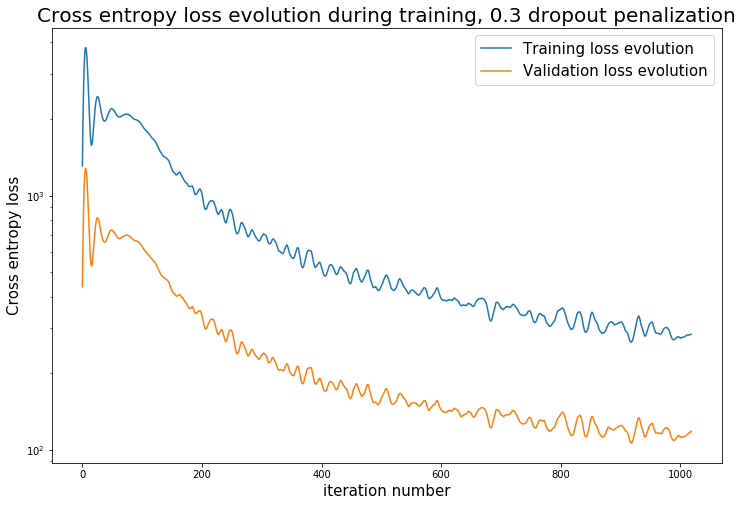

In [49]:
mlp.plot_loss_history()

## Questions:
#### - Did you succeed to train the MLP and get a high validation accuracy? <br> Display available metrics (training and validation accuracies, training and validation losses)

Yes, we are able to train the network with a validation accuracy of up to 97%. We have tested a few different models with varying hyperparameters and optimizers and all of them seem to converge to around the same accuracy. You can see these models above and the various metrics that we are able to display. We notice that the validation loss looks considerably lower than the training loss which can be a sign of undefitting but this is due to the fact that there are less validation samples than training examples. We still see that the curves follow the same trend so they should converge at the same rate.

#### - Plot the prediction for a given validation sample. Is it accurate?

After training, we can plot the model predictions for a given sample after passing through the softmax activation function. This gives us the probabilities that our model assigns to each label. A lot of the time this prediction is accurate but we can see that with certain samples, our model has a hard time giving a very confident prediction and will hesitate between a few labels. This is due to the fact that some samples in the MNIST dataset are quite difficult to guess even for a human and that we have also reduced the dimension of the data

#### - Compare the full gradient descent with the SGD.

Standard gradient descent is a lot slower to train than SGD but it is a lot smoother. It also seemed to take more iterations until the algorithm stopped. However, we found that because GD is so smooth in the training loss, instead of stopping early the training function until the loss levels out to 1e-4 delta. We found that this resulted almost in overfitting where the train loss became much lower than the validation loss which we established earlier to be the opposite normally. To fight this overfitting we could add dropout to fight this overfitting but it wouldnt change the fact that standard gradient descent is very slow and ressource intensive. 

#### - Play with the hyper parameters you have: the hidden size, the activation function, the initial step and the batch size. <br> Comment. Don't hesitate to visualize results.

After experimenting with all of the hyperparameters, it seems that they all have some influence over the model performance and it is possible that they could even interact with one another but here we will consider them seperately

- hidden size: The hidden size is directly proportional to our model complexity. We can have multiple layers of hidden neurons and each layer can have a different number of neurons. In our example, we are only considering a single hidden layer to make the calculations of gradients easier. From testing we noticed that having very few neurons (less than 20) in our hidden layer negatively impacted on accuracy as our model is not complex enough to model the data. on the other hand having a lot of hidden neurons tends to marginally increase validation accuracy and requires some dropout so that we dont overfit.

- activation function: We have tested two different activation functions: ReLU and sigmoid, from testing it seems like ReLU was better than the sigmoid because the model validation accuracy increassed faster. This is most likely due to the fact that the sigmoid's value range is not very big and it can easily saturate at 1 or 0 and cause some issues with the gradients. On the other hand, the derivative of the ReLU is much better at propagating the gradients and increassing training speed

- initial step: The initial step or learning rate is one of the most important hyperparameters in our model as it controls how fast or slow the model will 'learn'. The initial step is set to 0.1 which is quite high for neural networks but since our model is not very deep and the problem type is relatively simple, we can get away with such a high learning rate. if we turn it down to 1e-3 then the model takes considerably longer to converge

- batch size: when doing SGD, batch size is the number of samples that we will use to update our model parameters. The idea with SGD is that a smaller number of samples can still give a good representation of the data distribution in general. When performing backpropagation the step may not be in the right direction but overall we will still converge. A decent batch size is of around 64, we could go as low as 32 or even 16 without too much of a decrease in performance. Usually, there is no disadvantage with a high batch size only that it will slow down the time per epoch of our model. However, too small a batch size will result in poor training

#### - Once properly implemented, compare the training using early stopping, dropout, or both of them. <br> Why are these methods useful here?

Early stopping is both used to prevent overfitting and to know when to stop training when the loss evolution could be noisy. When we use SGD or dropout, ou training loss is very likely to be noisy which means that we cant rely on the delta between training loss at different steps as our stop parameter. Instead, early stopping looks at when the loss begins to slowly level out and stops it once it is not changing very much overall. 

#### - Once properly implemented, compare the training using momentum.

With momentum, training is much faster in almost any scenario. Without it and using SGD we converge in around 1500 iterations while we converge in 800 when using momentum. 

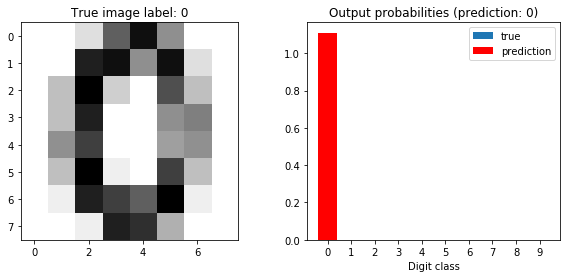

In [93]:
mlp.plot_validation_prediction(sample_id=42)

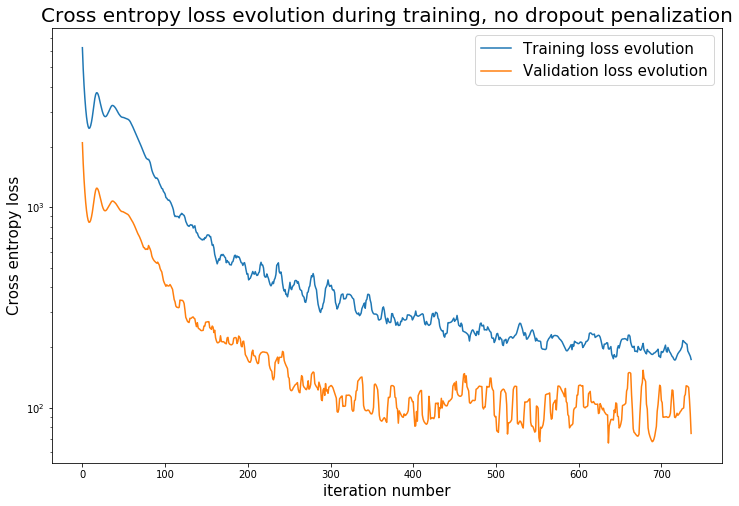

In [94]:
mlp.plot_loss_history()

# III - Multiclass classification MLP with Keras

#### - Implement the same network architecture with Keras;
    - First using the Sequential API
    - Secondly using the functional API

#### - Check that the Keras model can approximately reproduce the behavior of the Numpy model.

#### - Compute the negative log likelihood of a sample 42 in the test set (can use `model.predict_proba`).

#### - Compute the average negative log-likelihood on the full test set.

#### - Compute the average negative log-likelihood  on the full training set and check that you can get the value of the loss reported by Keras.

#### - Is the model overfitting or underfitting? (ensure that the model has fully converged by increasing the number of epochs to 500 or more if necessary).

In [95]:
X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y)
scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
X_tr = scaler.fit_transform(X_tr)
X_val = scaler.transform(X_val)

In [102]:
n_features = X[0].shape[0]

n_classes = len(np.unique(Y_tr))
n_hidden = 10

64


### Sequential

In [122]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


activation = "relu"
# activation = "sigmoid"

print('Model with {} activation'.format(activation))

keras_model = Sequential()
# TODO:
keras_model.add(Dense(50 , input_dim = n_features , activation=activation, kernel_initializer="normal" ) )
keras_model.add(Dropout(0.3))
                
keras_model.add(Dense(n_classes ,kernel_initializer="normal", activation="softmax"))
                
keras_model.compile(loss='categorical_crossentropy',
            optimizer="adam",
            metrics=['accuracy'])
                
keras_model.summary()

keras_model.fit(X_tr, to_categorical(Y_tr), validation_data=(X_val, to_categorical(Y_val) ), epochs=30,batch_size=32)

Model with relu activation
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 50)                3250      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 10)                510       
Total params: 3,760
Trainable params: 3,760
Non-trainable params: 0
_________________________________________________________________
Train on 1347 samples, validate on 450 samples
Epoch 1/30
1347/1347 [==============================] - 0s 259us/sample - loss: 2.2111 - accuracy: 0.3935 - val_loss: 2.0843 - val_accuracy: 0.7044
Epoch 2/30
1347/1347 [==============================] - 0s 49us/sample - loss: 1.9525 - accuracy: 0.6281 - val_loss: 1.7424 - val_accuracy: 0.7933
Epoch 3/30
1

### Functional

In [124]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

activation = "relu"
# activation = "sigmoid"

print('Model with {} activation'.format(activation))

inputs = Input(shape=(n_features,))
# TODO:

hidden_layer = Dense(50,activation=activation)(inputs)

dropout_layer = Dropout(0.3)(hidden_layer)

output_layer= Dense(n_classes,activation="softmax")(dropout_layer)

model = Model(inputs = inputs, outputs = output_layer)

model.compile(optimizer="adam",loss = "categorical_crossentropy",metrics=['accuracy'])


model.fit(X_tr,to_categorical(Y_tr), validation_data=(X_val, to_categorical(Y_val) ), epochs = 20, batch_size=32)


Model with relu activation
Train on 1347 samples, validate on 450 samples
Epoch 1/20
1347/1347 [==============================] - 0s 255us/sample - loss: 2.2533 - accuracy: 0.1774 - val_loss: 1.9958 - val_accuracy: 0.4644
Epoch 2/20
1347/1347 [==============================] - 0s 45us/sample - loss: 1.8683 - accuracy: 0.4477 - val_loss: 1.6248 - val_accuracy: 0.7244
Epoch 3/20
1347/1347 [==============================] - 0s 50us/sample - loss: 1.5618 - accuracy: 0.5939 - val_loss: 1.3064 - val_accuracy: 0.8289
Epoch 4/20
1347/1347 [==============================] - 0s 47us/sample - loss: 1.3033 - accuracy: 0.6897 - val_loss: 1.0380 - val_accuracy: 0.8778
Epoch 5/20
1347/1347 [==============================] - 0s 48us/sample - loss: 1.0863 - accuracy: 0.7365 - val_loss: 0.8271 - val_accuracy: 0.8956
Epoch 6/20
1347/1347 [==============================] - 0s 49us/sample - loss: 0.9452 - accuracy: 0.7647 - val_loss: 0.6795 - val_accuracy: 0.9178
Epoch 7/20
1347/1347 [=====================

#### Now that you know if the model is underfitting or overfitting:

It looks like the model is underfitting just a little because we get a higher validation accuracy than training accuracy.

#### - In case of underfitting, can you explain why ? Also change the structure of the 2 previous networks to cancell underfitting
If the model is undefitting, then that is a sign that our model complexity is not high enough and is not able to model that data distribution. If this is the case then we can increase our hidden layer size or simply add more hidden layers but not too many as this could lead to overfitting. 


#### - In case of overfitting, explain why and change the structure of the 2 previous networks to cancell the overfitting
If our model is overfitting then there are two possible options:
1) reduce the model size by removing some hidden layers if there are too many or by decreassing the number of hidden neurons
2) add some dropout to the layers as a regularization technique